<a href="https://colab.research.google.com/github/petr-ngn/CNN_Real_Estate_Offices_Amenities_Listing/blob/main/CNN_Real_Estate_Offices_Amenities_Listing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-label Classificiation of real-estate offices' amenities using Convolutional Neural Networks (CNN)**

*Author:* [**Petr Nguyen**](https://linkedin.com/in/petr-ngn)

- _*Collaborators:*_ [**Ilya Tsakunov**](https://www.linkedin.com/in/ilya-tsakunov-14192620b/), [**Peter Kachnic**](https://www.linkedin.com/in/peterkachnic/), [**Katerina Nekvindova**](https://www.linkedin.com/in/kateřina-nekvindová-119050178/), [**Adrian Harvan**](https://www.linkedin.com/in/adrian-harvan/), [**Simona Dohova**](https://www.linkedin.com/in/simona-dohová-182427153/), **Marco Vezzola**

## **Project description**

Within the course __*Trends in business analytics I (4IZ481)*__ at Faculty of Informatics and Statistics, Prague University of Economics and Business, we had to introduce a business solution of unstructured data usage with partial implementation in Python. Our team came up with a business solution which combines both image processing and natural language processing.

Particularly, based on our research, we introduced a model for object detection which helps to detect and recognize the real estates' amenities and then outputs a list of amenities which given real estate has, based on the provided real-estate pictures. Afterwards, such predicted amenities' lists are used as keywords for text generator of property listing within real-estate advertisement.

![alt_text](https://drive.google.com/uc?export=view&id=1AN7g0RGtmGN5UIm-Ilnx2SgFsPBZ7UdJ)

We were provided with web-scrapped dataset of German offices' pictures and CSV file with the annotations, which contains 457 offices and 15 types of amenities.

![alt_text](https://drive.google.com/uc?export=view&id=1v1UJ0qyIL-AGP1XnTCPNFg0zhR8Vmh3d)

![alt_text](https://drive.google.com/uc?export=view&id=12qGrkwY-d0LRgslVpxLLFfY-zgaWSQG3)

Our partial Python solution regarded an image processing of real-estate amenities using Keras and Tensorflow. After image processing such as loading the pictures as 3D arrays with further reshaping, normalization and tensor conversion, we split them into training set for model building and weight optimization, validation set for hyperparameter tuning and optimization, and test set for the model evaluation.

We developed a custom Convolutional Neural Network (CNN) for multi-label clasiffication in order to predict a probability score for each amenity's occurrence of given office. We optimized CNN's hyperparameters with Bayesian Optimization while minizing a binary cross entropy loss function, where we tuned:
- the number of convolutional blocks,
- the value of the filters within a single convolution,
- the type of the pooling (whether use Max Pooling or Average Pooling),
- the number of units in the dense layer,
- the value of the dropout rate in the dropout layer as a regularization constraint with respect to the overfitting,
- the value of the learning rate of stochastic gradient descent method namely
-nud, namely Adaptive Moment Estimation (Adam) optimizer.

Such developed and optimized model also includes batch normalization layers and uses sigmoid function for multilabel-classification (assuming the predicted probabilities are independent) and is visualized below with following tuned hyperparameters. 

![alt_text](https://drive.google.com/uc?export=view&id=1dNweZjb49N3rURWxbqetAMWxdHDK7v9u)

![alt_text](https://github.com/petr-ngn/CNN_Real_Estate_Offices_Amenities_Listing/blob/main/plots/Model/CNN_PN__Visual_Keras.png?raw=true)

Within the evaluation, we averaged the predicted probabilities to get aggregated probabilities on the office level, which were then used for a classification of the amenities' occurrences. By taking the predicted amenities' occurrences (predicted labels) or the predicted probabilities and the actual amenities occurrences (true labels), we calculate overall metrics F1 score, accuracy, precision, recall or AUC. For instance, the following graph depicts an AUC scores' distribution across the amenities and samples.

![alt_text](https://drive.google.com/uc?export=view&id=13NxjZ2uyBLjShkpIdNYR5ux_Ec08djpu)

The main output of this project is a list of predicted amenities, which given offices should have. Such lists can be then used as an input, as already mentioned, for a text generator of property listing within real-estate advertisement.

!![image.png](https://drive.google.com/uc?export=view&id=1bSbYl0LW5-Zg5_dgKcCa8jWiYPcHcnUo)

For the further development, we recommend following:
- Use pictures with a better quality and higher resolution
- Proper pictures' selection - use only relevant pictures (*we do not want model train on non-relevant pictures such as a picture of a building from the outside etc*).
- Increase training and validation size (*in order to increase model model performance*)
- Perform an image augmentations - especially for the offices' pictures having such amenities which do not occur that often in the dataset (*in order to deal with imbalanced classes*).
- Re-definition of amenities labels (*some amenities are hardly observed from pictures*).
- Choosing a different, ideally an optimal, threshold for classification of amenities' occurrences.

In conclusion, with respect to our business case for generating property listings of real estates based on provided photos, we deem our solution appropriate. If we implement the recommendations mentioned above, we would be able to increase model performance even more which would result in more accurate generated property listings. Thus, this would help to save time costs, improve SEO or increase sales in the real-estate sector using more efficient real-estate advertisement.

## **Enviroment preparation**

Installing and importing relevant libraries

In [ ]:
!pip install keras-tuner
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.5 MB/s 
     |████████████████████████████████| 1.6 MB 30.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 4.8 MB/s 


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
import kerastuner as kt
import visualkeras
from google.colab import drive
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
pd.set_option('display.max_colwidth', 400)
tf.get_logger().setLevel('ERROR')

Mounting the files from Google Drive
- this will not work for other viewers, since it's not possible to mount files from someone else's Google Drive.

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Input parameters' initialization

In [ ]:
seed = 42
num_train_offices = 300
num_valid_offices = 79
num_test_offices = 78
num_train_valid_offices = num_train_offices + num_valid_offices
dim_size = 100
directory_path = '/content/gdrive/MyDrive/office_data/'
filename = 'office_data_processed_20221203.csv'

Setting a working directory path

In [ ]:
os.chdir(directory_path)

##**Data loading and preprocessing**

Reading and processing the raw csv file containing the labels for each office.

In [ ]:
def read_prep_csv(filename):

    #Removing useless columns
    df = pd.read_csv(filename).drop(['Unnamed: 0', 'photos',
                                    'description', 'parking_available'],
                                    axis = 1)
    #Since the labels are stored in a single cell, we split them using dummy encoding.
    dumm_df =  pd.concat((df,
                          df['amenities'].str.get_dummies(',')),
                          axis = 1).drop('amenities', axis = 1)

    #Converting the data frame into integers.
    for col in dumm_df.columns:
        dumm_df[col] = dumm_df[col].astype('int')

    return dumm_df

In [ ]:
df = read_prep_csv(filename)
df

,location_id,24_hour_security,air_conditioning,bike_rack,community_events,elevator,garden,gym,personal_lockers,pets_allowed,reception,relaxation_room,shared_kitchen,shower,terrace,wheelchair
0,54234,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1,19366,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
2,19365,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
3,41652,1,1,0,0,1,0,0,1,0,1,0,1,0,0,0
4,19371,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,12652,1,0,0,1,1,0,0,0,0,1,1,1,0,0,0
453,12653,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0
454,12329,1,0,0,1,1,0,0,1,0,1,1,1,0,0,0
455,12331,1,0,0,1,1,0,0,1,0,1,1,1,0,0,0


Storing the labels' names.

In [ ]:
label_names = list(df.columns)[1:]
display(label_names)

['24_hour_security',
 'air_conditioning',
 'bike_rack',
 'community_events',
 'elevator',
 'garden',
 'gym',
 'personal_lockers',
 'pets_allowed',
 'reception',
 'relaxation_room',
 'shared_kitchen',
 'shower',
 'terrace',
 'wheelchair']

Visualizing the frequencies per each label.

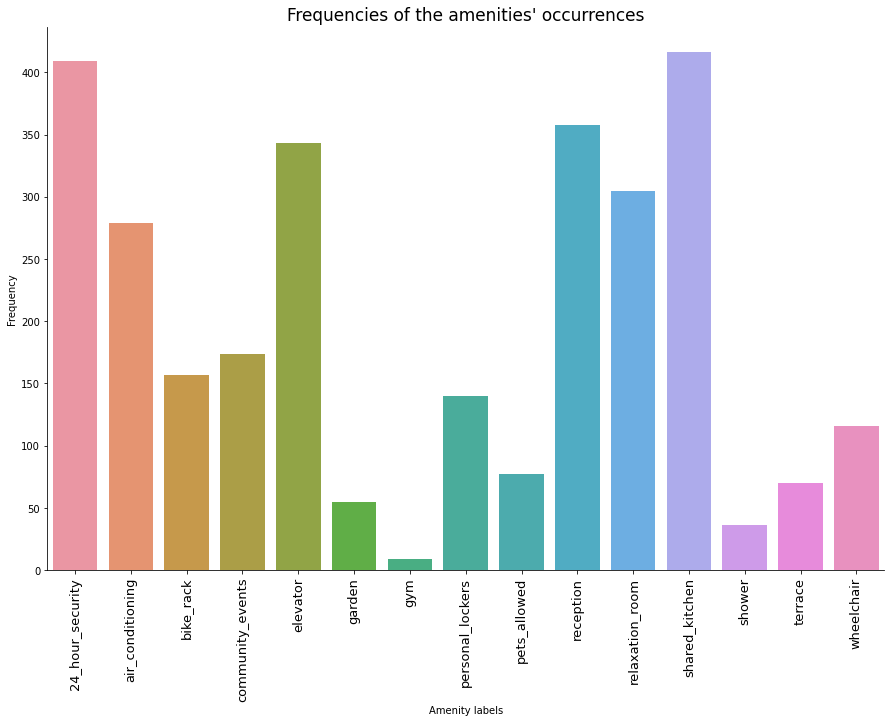

In [ ]:
plot_df = pd.DataFrame(df[label_names].sum(), columns = ['count']).reset_index().rename(columns = {'index':'labels'})
plt.figure(figsize = (15, 10))
sns.barplot(plot_df['labels'], plot_df['count'])
plt.xticks(rotation = 90, size = 13)
plt.title("Frequencies of the amenities' occurrences", size = 17)
plt.ylabel('Frequency')
plt.xlabel('Amenity labels')
axes = plt.gca()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
plt.savefig('plots/Amenities Distribution/Frequency_Distribution_Labels.png')
plt.show()

Splitting the offices.

In [ ]:
def train_test_split_off(df, num_train_offices, num_valid_offices, num_test_offices, seed):

  np.random.seed(seed)

  train_offices = np.random.choice(df['location_id'], num_train_offices, replace = False)
  valid_offices = np.random.choice(df[~df['location_id'].isin(train_offices)]['location_id'], num_valid_offices, replace = False)
  test_offices = np.random.choice(df[~df['location_id'].isin(np.concatenate((train_offices, valid_offices)))]['location_id'], num_test_offices, replace = False)

  return (train_offices, valid_offices, test_offices)

In [ ]:
train_offices, valid_offices, test_offices = train_test_split_off(df, num_train_offices, num_valid_offices, num_test_offices, seed)

print(f'number of offices in training set: {len(train_offices)}')
print(f'number of offices in validation set: {len(valid_offices)}')
print(f'number of offices in test set: {len(test_offices)}')

number of offices in training set: 300
number of offices in validation set: 79
number of offices in test set: 78


Loading and storing the offices' pictures as 3D arrays and the numbers of pictures per office.

In [ ]:
def load_images(offices):

    #Initializing the lists for storing both pictures and number of pictures for each office.
    imgs = []
    num_pics = []

    #For each office, load and store all the pictures and the number of pictures into respective lists.
    for off in offices:

        folder_path = f'photos/office_{off}/'

        i = 0

        for img_name in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path, img_name))

            if img is not None:

                imgs.append(img)
                i += 1

        num_pics.append(i)

    return imgs, num_pics

In [ ]:
train_imgs, train_num_pics = load_images(train_offices)
print(f'number of pictures in training set: {sum(train_num_pics)}')

number of pictures in training set: 1657


In [ ]:
valid_imgs, valid_num_pics = load_images(valid_offices)
print(f'number of pictures in validation set: {sum(valid_num_pics)}')

number of pictures in validation set: 431


In [ ]:
test_imgs, test_num_pics = load_images(test_offices)
print(f'number of pictures in test set: {sum(test_num_pics)}')

number of pictures in test set: 415


In [ ]:
train_valid_imgs, train_valid_num_pics = train_imgs + valid_imgs, train_num_pics + valid_num_pics
print(f'number of pictures in joind training and validation set: {sum(train_valid_num_pics)}')

number of pictures in joind training and validation set: 2088


Processing of images including resizing, normalization and conversion of numpy arrays into tensors.

In [ ]:
def prep_images(imgs, resize_dim = 100, normalization = True, tf_conversion = True):

    prep_images = []

    for img in imgs:
        res_norm_img = cv2.resize(img, (resize_dim, resize_dim)) #Resizing the pictures.
        prep_images.append(res_norm_img)
    
    if normalization:
        prep_images = [img/255.0 for img in prep_images] #Normalizing the pictures.

    if tf_conversion:
        prep_images = tf.stack(prep_images) #Conversion of numpy arrays into tensors.

    return prep_images

In [ ]:
train_tf_imgs = prep_images(train_imgs, resize_dim = dim_size, normalization = True, tf_conversion = True)

In [ ]:
valid_tf_imgs = prep_images(valid_imgs, resize_dim = dim_size, normalization = True, tf_conversion = True)

In [ ]:
test_tf_imgs = prep_images(test_imgs, resize_dim = dim_size, normalization = True, tf_conversion = True)

In [ ]:
train_valid_tf_imgs = prep_images(train_valid_imgs, resize_dim = dim_size, normalization = True, tf_conversion = True)

In [ ]:
print(f'training shape: {train_tf_imgs.shape}')
print(f'validation shape: {valid_tf_imgs.shape}')
print(f'test shape: {test_tf_imgs.shape}')
print(f'joined training and validation shape: {train_valid_tf_imgs.shape}')

training shape: (1657, 100, 100, 3)
validation shape: (431, 100, 100, 3)
test shape: (415, 100, 100, 3)
joined training and validation shape: (2088, 100, 100, 3)


Processing of the classes/labels.

In [ ]:
def prep_labels(df, offices, num_pics):

    #Initializing a data frame for storing the labels for each office.
    labels_df = pd.DataFrame(columns = list(df.columns)[1:])

    #Since we don't have the labels for each picture but rather for each office instead, we gonna replicate the labels for all pictures per office.

    #For each ffice, replicate the labels for all pictures of given office.
    for num, pic in zip(num_pics, offices): #For each office (with corresponding number of pictures)
        for _ in range(num): #For each picture of given office.
            labels_row = df.query(f'location_id == {pic}').drop('location_id',
                                                                axis = 1) #Filter the labels of given office
            labels_df = pd.concat((labels_df, labels_row)) #Store the labels into a data frame.

    #Conversion of the labels from data frame into numpy arrays with subsequent conversion into tensors.
    tf_labels = tf.constant([labels_df.to_numpy()])[0]

    return tf_labels

In [ ]:
train_valid_offices = np.concatenate((train_offices, valid_offices))

In [ ]:
train_tf_labels = prep_labels(df, train_offices, train_num_pics)
valid_tf_labels = prep_labels(df, valid_offices, valid_num_pics)
test_tf_labels = prep_labels(df, test_offices, test_num_pics)
train_valid_tf_labels = prep_labels(df, train_valid_offices, train_valid_num_pics)

## **CNN Modelling & Bayesian Optimization**

Function for model building as an input for Bayesian Optimization.

We tune:
- the number of convolutional blocks,
- the value of the filters (number of output filters in the convolution),
- the type of the pooling (whether use Max Pooling or Average Pooling),
- the number of units in the dense layer,
- the value of the dropout rate in the dropout layer in order to prevent overfitting,
- the value of the learning rate of stochastic gradient descent method in the Adam optimizer.

In [ ]:
def model_building(hp):

  global dim_size

  #Input layer
  inputs = Input(shape = (dim_size, dim_size, 3))
  x = inputs

  #Tuning a number of convolutional blocks
  for i in range(hp.Int('conv_blocks', min_value = 3, max_value = 5, default = 3)):
    
    #Tuning the number of convolution's output filters
    filters = hp.Int('filters_' + str(i), min_value = 32,
                     max_value = 256, step = 32) 
    
    for _ in range(2):

      x = Conv2D(filters, kernel_size=(3, 3), padding = 'same',
                 activation = 'relu')(x)
      x = BatchNormalization()(x)

    #Tuning the pooling type in the convolutional block
    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
        x = MaxPooling2D()(x)
    else:
        x = AveragePooling2D()(x)
    
    #Tuning the dropout rate in the dropout layer in the convolutional block
    x = Dropout((hp.Float('dropout', 0, 0.5, step = 0.05, default = 0.5)))(x)

  x = Flatten()(x)

  #Tuning the number of units in the dense layer
  x = Dense(hp.Int('Dense units' ,min_value = 30,
                   max_value = 100, step = 10, default = 50),
                  activation='relu')(x)

  #Tuning the dropout rate in the dropout layer 
  x = Dropout((hp.Float('dropout', 0, 0.5, step = 0.05, default = 0.5)))(x)

  global label_names

  #Final output layer for multi-label classification using sigmoid function as we assume that each amenity label's probability is independent to each other.
  outputs = Dense(len(label_names), activation = 'sigmoid')(x)
  
  #Mapping the input and output layers to the model
  model = Model(inputs, outputs, name = 'CNN_PN')

  #Model compilation:
    #Tuning the learning rate of the stochastic gradient method in the Adam optimizer.
    #Minimizing a binary cross entropy loss function and maximizing an accuracy.
    #We compute the binary cross entropy for each label separately and then sum them up for the complete loss.
    
  model.compile(optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate',
                                                              min_value = 1e-4,
                                                              max_value =1e-2,
                                                              sampling='log')), 
                loss = 'binary_crossentropy', metrics = ['accuracy'])

  return model

Initialization of Bayesian Optimization object while minimizing validation loss.
- With 100 trials of model configurations to test.

In [ ]:
bayes_opt = kt.tuners.BayesianOptimization(model_building, objective = 'val_loss', max_trials = 100, seed = seed)

Hyperparameter tuning using Bayesian Optimization for search the best hyperparameter values.
- Using 100 epochs and an early stopping which stops the training when a monitored metric has stopped improving after 69 epochs.

In [ ]:
bayes_opt.search(train_tf_imgs, train_tf_labels,
                 validation_data = (valid_tf_imgs, valid_tf_labels),
                 epochs = 100,
                 callbacks = [EarlyStopping(patience = 69)])

Accessing the best hyperparameters' values

In [ ]:
best_hypers = bayes_opt.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
display(best_hypers.values)

{'conv_blocks': 5,
 'filters_0': 256,
 'pooling_0': 'max',
 'dropout': 0.5,
 'filters_1': 32,
 'pooling_1': 'max',
 'filters_2': 256,
 'pooling_2': 'avg',
 'Dense units': 30,
 'learning_rate': 0.01,
 'filters_3': 256,
 'pooling_3': 'avg',
 'filters_4': 32,
 'pooling_4': 'avg'}

Final tuned model building

In [ ]:
final_model = bayes_opt.hypermodel.build(best_hypers)

Model visualization

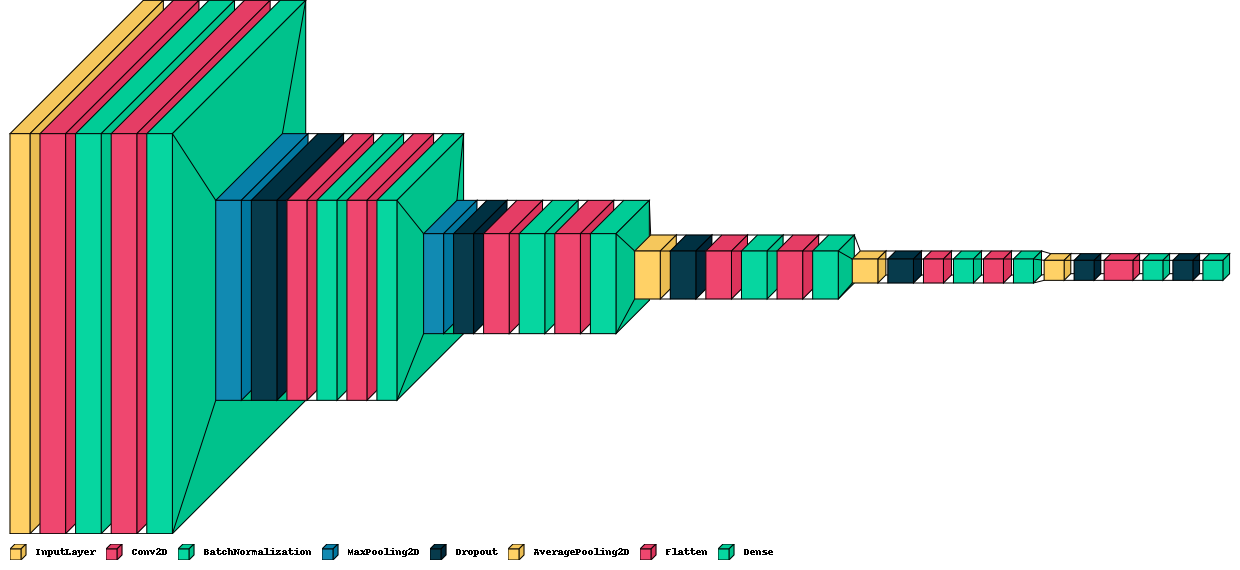

In [ ]:
#Visual Keras
visualkeras.layered_view(final_model, legend=True)

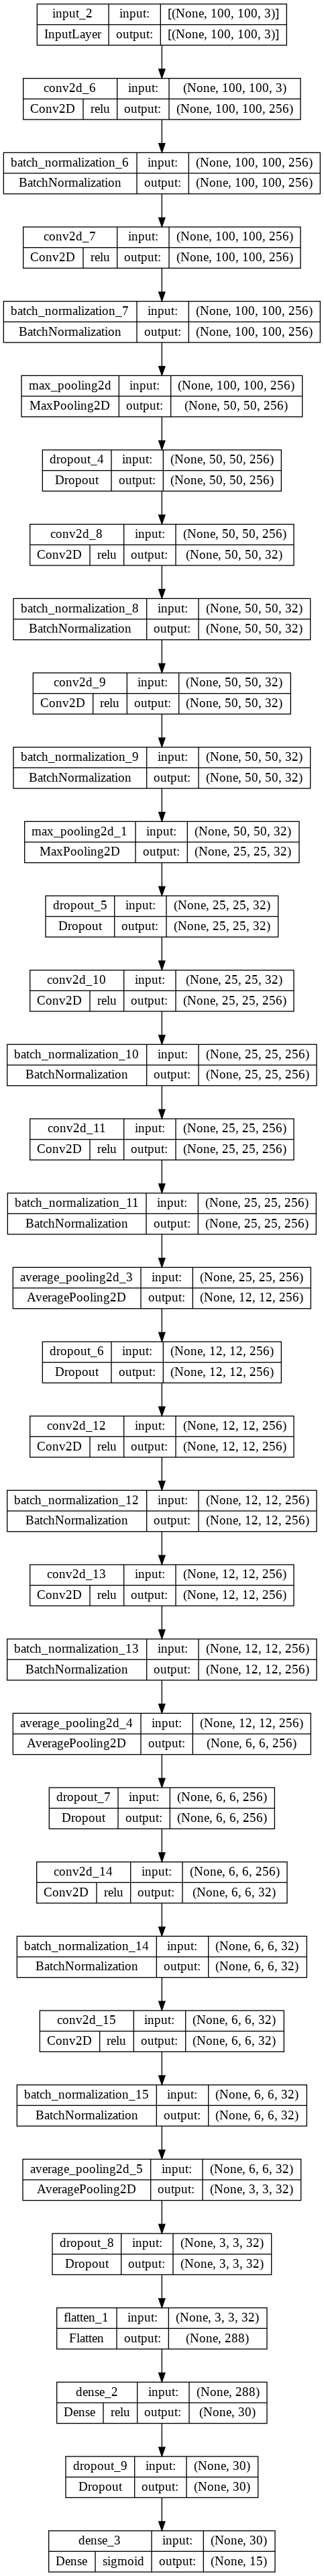

In [ ]:
#Keras Model Plot
tf.keras.utils.plot_model(final_model, show_shapes = True, show_layer_activations=True,
                          show_layer_names = True, expand_nested = True,
                          to_file='plots/Model/CNN_PN__Keras_Plot_Model.png')

Model summary

In [ ]:
final_model.summary()

Model: "CNN_PN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 256)     7168      
                                                                 
 batch_normalization_6 (Batc  (None, 100, 100, 256)    1024      
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 256)     590080    
                                                                 
 batch_normalization_7 (Batc  (None, 100, 100, 256)    1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 256)      0    

Final model training on the joined training and validation set
- Since we already used an information from validation set when searching for the best hyperparameters' values, we will increase the size of the sample for the model training in order to increase the model performance and better generalization.
- Again, using 100 epochs and an early stopping which stops the training when a monitored metric has stopped improving after 69 epochs.

In [ ]:
history = final_model.fit(train_valid_tf_imgs, train_valid_tf_labels,
                          epochs = 100, verbose = 1,
                          callbacks = [EarlyStopping(patience = 69)])

Epoch 1/100
66/66 [==============================] - 15s 45ms/step - loss: 0.5532 - accuracy: 0.3745
Epoch 2/100
66/66 [==============================] - 3s 39ms/step - loss: 0.4847 - accuracy: 0.2562
Epoch 3/100
66/66 [==============================] - 3s 39ms/step - loss: 0.4758 - accuracy: 0.2830
Epoch 4/100
66/66 [==============================] - 3s 40ms/step - loss: 0.4670 - accuracy: 0.1839
Epoch 5/100
66/66 [==============================] - 3s 39ms/step - loss: 0.4638 - accuracy: 0.3511
Epoch 6/100
66/66 [==============================] - 3s 40ms/step - loss: 0.4602 - accuracy: 0.3467
Epoch 7/100
66/66 [==============================] - 3s 40ms/step - loss: 0.4522 - accuracy: 0.2352
Epoch 8/100
66/66 [==============================] - 3s 39ms/step - loss: 0.4526 - accuracy: 0.3568
Epoch 9/100
66/66 [==============================] - 3s 39ms/step - loss: 0.4519 - accuracy: 0.2002
Epoch 10/100
66/66 [==============================] - 3s 39ms/step - loss: 0.4511 - accuracy: 0.269

Saving the final model

In [ ]:
final_model.save('CNN_PN.h5')
final_model.save('CNN_PN')

# **Evaluation**

Dictionary of offices and their images' indices.

In [ ]:
def office_indexing(offices, num_pics):
    offices_dict = {}

    k = 0 #Initializing an index
    ind_list = [] #Initializing a list for storing starting and ending indices per each office.

    for office, no_pic in zip(offices, num_pics):
        #k is an starting index for given office
            #An ending index is the starting index incremented by the number of pictures of given office.
            #Since the Python indexing starts from 0, we need to decrease the the ending index by 1.
        ind_list = [k, k+no_pic-1] 
        offices_dict[office] = ind_list
        
        #Adjusting the starting index for next office by incremeting the index by number of pictures of the previous office.
        k += no_pic

    return offices_dict

In [ ]:
train_offices_dict = office_indexing(train_offices, train_num_pics)
valid_offices_dict = office_indexing(valid_offices, valid_num_pics)
test_offices_dict = office_indexing(test_offices, test_num_pics)

Choosing a single office(s) for further single evaluation(s).

In [ ]:
np.random.seed(seed)

single_train_office = np.random.choice(train_offices, 1)[0]
single_valid_office = np.random.choice(valid_offices, 1)[0]
single_test_office = np.random.choice(test_offices, 1)[0]

Plotting the pictures of given office.

In [ ]:
def plot_office(office):
    path_pic =  f'photos/office_{office}/'

    for pic in os.listdir(path_pic):
        img = cv2.imread(os.path.join(path_pic, pic))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'Office {office} ({os.path.join(path_pic, pic).split("/")[-1]})', size = 15)
        plt.show()

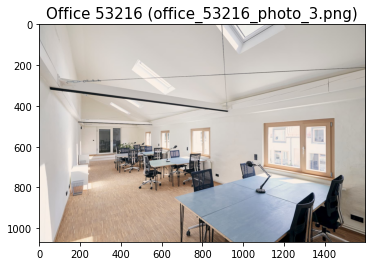

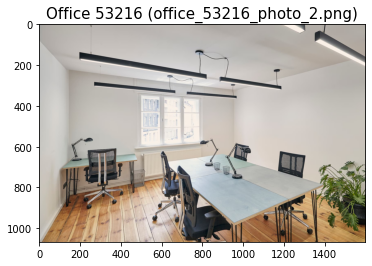

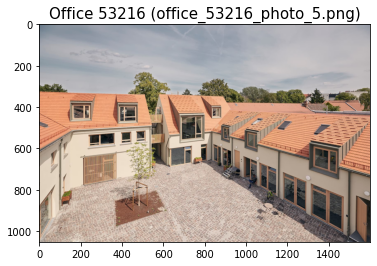

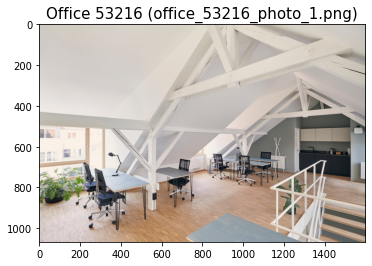

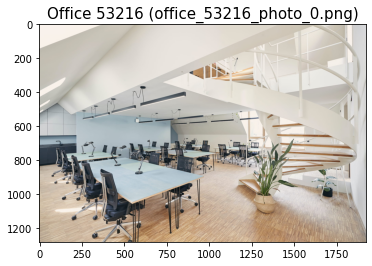

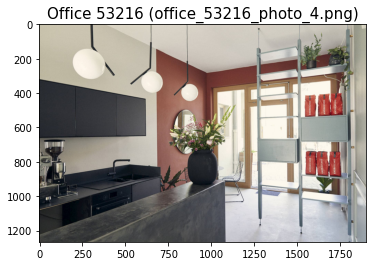

In [ ]:
plot_office(single_test_office)

Class predictions based on the trained model, for given office.

In [ ]:
def office_predictions(model, tf_imgs, offices_dict, office):
    
    start_ind = min(offices_dict[office])
    end_ind = max(offices_dict[office]) + 1

    office_probs= model.predict(tf_imgs[start_ind:end_ind])

    return office_probs

In [ ]:
single_train_office_preds = office_predictions(final_model, train_tf_imgs, train_offices_dict, single_train_office)
single_valid_office_preds = office_predictions(final_model, valid_tf_imgs, valid_offices_dict, single_valid_office)
single_test_office_preds = office_predictions(final_model, test_tf_imgs, test_offices_dict, single_test_office)

1/1 [==============================] - 0s 264ms/step


Evaluation of the single office's predictions based on predicted probabilites.
- Based on predicted amenities' probabilities of each photo of given office, we average them to get the aggregated amenities' probabilities of given office.
- based on the aggregated probabilities for each amenity label, we then use the default threshold 0.5 for a classification in order to get a predicted class for each amenity label (1 what is being above threshold, else 0).
- Then, we compare the predicted classes with the true classes in order to get the outcome, whether the the class for each amenity has been correctly classified.
  - Whether the true occurrences of amenity labels have been indeed correctly classified as true occurrences, or
  - Whether the true non-occurrences of amenity labels have been indeed correctly classified as true-non occurrences.

In [ ]:
def office_evaluation(predictions, label_names, df, office):

    #Storing predicted probabilites and the the label names into a data frame.
    eval_df = pd.DataFrame(pd.DataFrame(predictions, columns = label_names).mean(),
                           columns = ['prob']).reset_index().rename(columns = {'index':'var'})

    #Classification of classes (occurrences) based on probabilities with a default threshold 0.5.
    eval_df['pred'] = eval_df['prob'].apply(lambda x: 1 if x > 0.5 else 0)
    
    #Joining the predicted classes (occurrences) with the true classes (occurrences).
    eval_df = pd.concat((eval_df,
                        pd.DataFrame(df[df['location_id'] == office].drop('location_id', axis = 1).values).transpose()),
                        axis=1).rename(columns = {'index':'var', 0:'true'})

    #Indicator whether the predicted class (occurrence) is the same as the true class (occurrence).
    eval_df['outcome'] = [1 if i == j else 0 for i, j in zip(eval_df['pred'], eval_df['true'])]

    return eval_df

In [ ]:
single_train_eval_df = office_evaluation(single_train_office_preds, label_names, df, single_train_office)
single_valid_eval_df = office_evaluation(single_valid_office_preds, label_names, df, single_train_office)
single_test_eval_df = office_evaluation(single_test_office_preds, label_names, df, single_train_office)

In [ ]:
display(single_train_eval_df)

,var,prob,pred,true,outcome
0,24_hour_security,0.942626,1,1,1
1,air_conditioning,0.650849,1,1,1
2,bike_rack,0.618233,1,1,1
3,community_events,0.678476,1,1,1
4,elevator,0.804237,1,1,1
5,garden,0.227929,0,1,0
6,gym,0.021669,0,0,1
7,personal_lockers,0.453865,0,1,0
8,pets_allowed,0.303990,0,1,0
9,reception,0.799860,1,1,1


In [ ]:
display(single_valid_eval_df)

,var,prob,pred,true,outcome
0,24_hour_security,0.935868,1,1,1
1,air_conditioning,0.771890,1,1,1
2,bike_rack,0.113316,0,1,0
3,community_events,0.121890,0,1,0
4,elevator,0.856824,1,1,1
5,garden,0.018129,0,1,0
6,gym,0.002393,0,0,1
7,personal_lockers,0.134724,0,1,0
8,pets_allowed,0.016221,0,1,0
9,reception,0.863835,1,1,1


In [ ]:
display(single_test_eval_df)

,var,prob,pred,true,outcome
0,24_hour_security,0.862669,1,1,1
1,air_conditioning,0.480905,0,1,0
2,bike_rack,0.384022,0,1,0
3,community_events,0.405872,0,1,0
4,elevator,0.688919,1,1,1
5,garden,0.128051,0,1,0
6,gym,0.020743,0,0,1
7,personal_lockers,0.355339,0,1,0
8,pets_allowed,0.202713,0,1,0
9,reception,0.689370,1,1,1


Plotting the probabilities per each amenity label of given office.
- If the probability is above the threshold 0.5 (red line), hence it's classified/predicted as 1 (predicted occurrence of given amenity label), else 0 (predicted non-occurrence of given amenity label).
- What is being colored as an orange bar, hence the true class is 1 (true occurrence of given amenity label).
- What is being colored as a green bar, the true label is 0 (true non-occurrence of given amenity label).
- The desire outcome is either the orange bar being above the threshold and/or green bar being below the threshold.
  - In other words, the true occurrences shall be classified as occurrences and true non-occurrences shall be classified as non-occurrences.
- Moreover, we calculate the metrics on the office level, such as accuracy, F1 score, precision, recall or AUC.
  - AUC is being calculated using the true classes (intergers 0 or 1) and the predicted probabilities (float raning from 0.0 to 1.0).
  - Whereas the other metrics derived from confusion matrix are being calculated using the true  classes (intergers 0 or 1) and the predicted classes (intergers 0 or 1).

In [ ]:
def plot_office_evaluation(eval_df, office):
    
    #Plot initialization
    plt.figure(figsize=(25,10))
    sns.barplot(data = eval_df, x = 'var',y='prob', hue = 'true', palette = 'Set2')
    plt.axhline(y = 0.5, color = 'r', linestyle = '-')
    plt.xticks(rotation = 90, size = 13)
    plt.yticks(size = 14)

    #Metrics calculation
    acc = f'Accuracy: {accuracy_score(eval_df.true, eval_df.pred)*100:.2f}%'
    f1 = f'F1: {f1_score(eval_df.true, eval_df.pred)*100:.2f}%'
    recall = f'Recall: {recall_score(eval_df.true, eval_df.pred)*100:.2f}%'
    precision = f'Precision: {precision_score(eval_df.true, eval_df.pred)*100:.2f}%'
    auc = f'AUC: {roc_auc_score(eval_df.true, eval_df.prob)*100:.2f}%'

    #Plotting a box with the calculated metrics
    plt.text(-0.3,1.05,'\n'.join([acc, f1, recall, precision, auc]),
             fontsize = 14, bbox = dict(facecolor = 'pink', alpha = 0.7))
    
    #Adjusting the plot's properties
    plt.title(f'Office {office} - Probability distribution', size = 17)
    plt.ylim(0.0, 1.0+.05)
    plt.ylabel('Probability')
    plt.xlabel('Amenity labels')

    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    
    #Exporting the plot
    folder_name = f'plots/Evaluation/Single office'
    pic_name = f'Office_{office}_Distribution_Evaluation.png'
    plt.savefig(os.path.join(folder_name, pic_name))

    plt.show()

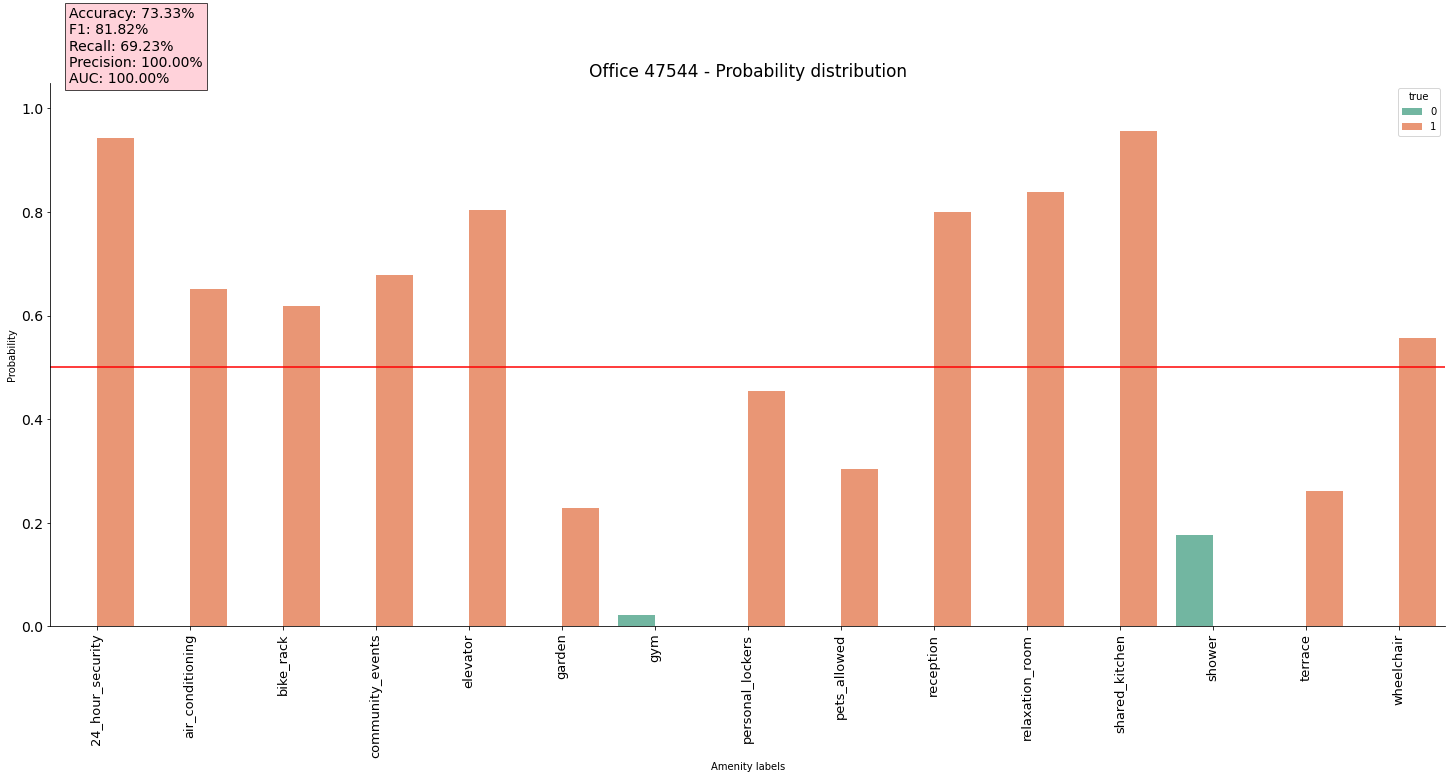

In [ ]:
plot_office_evaluation(single_train_eval_df, single_train_office)

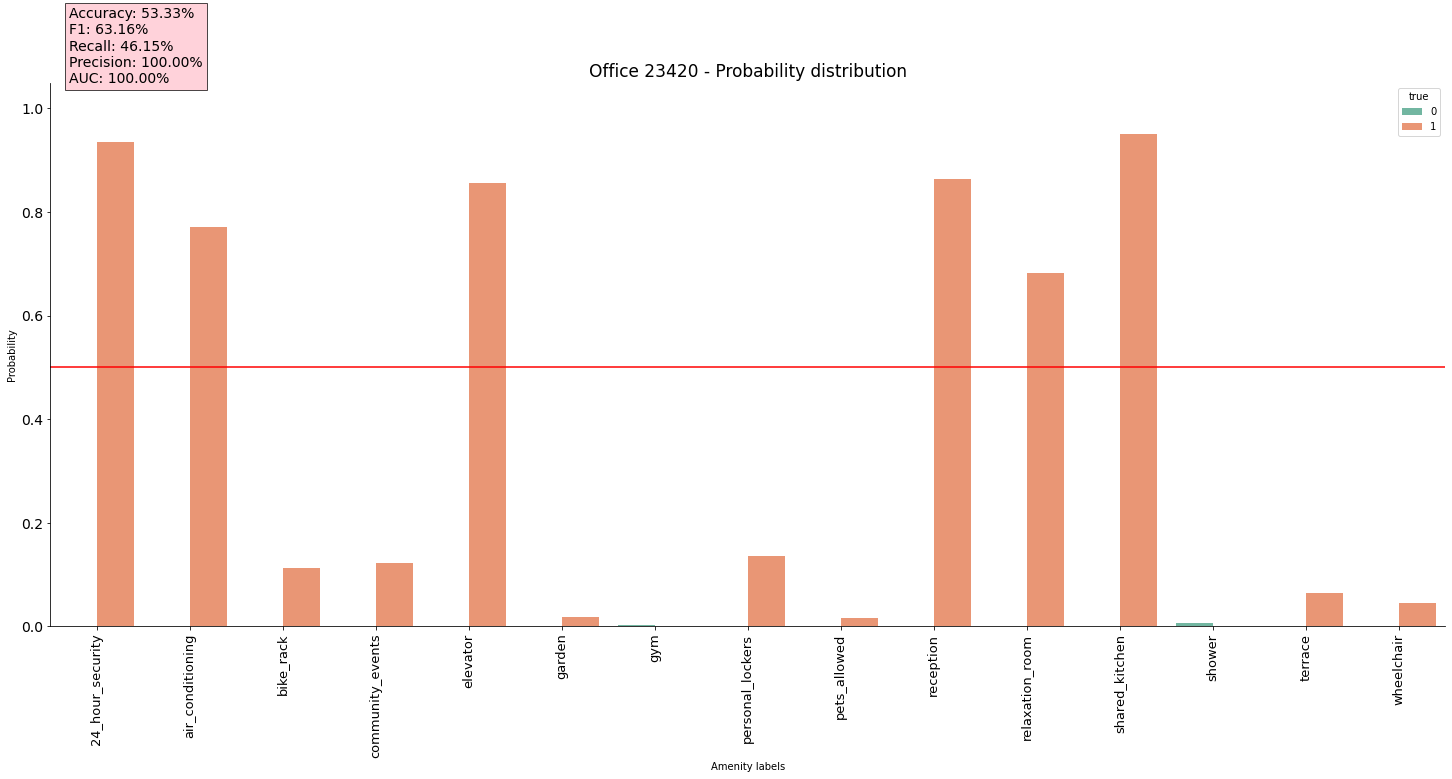

In [ ]:
plot_office_evaluation(single_valid_eval_df, single_valid_office)

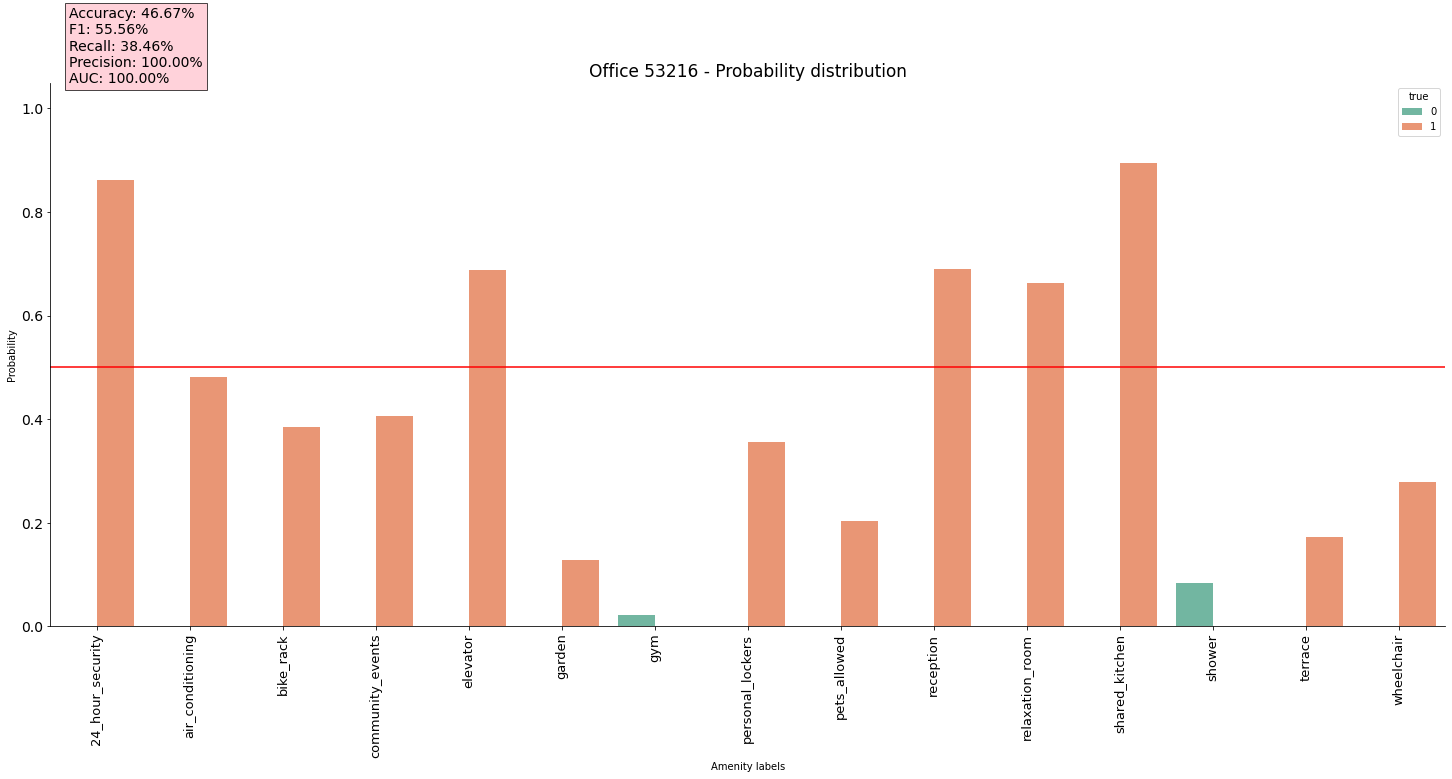

In [ ]:
plot_office_evaluation(single_test_eval_df, single_test_office)

Predictions on the whole training/validation/test set.

In [ ]:
train_all_predictions = final_model.predict(train_tf_imgs)

52/52 [==============================] - 2s 25ms/step


In [ ]:
valid_all_predictions = final_model.predict(valid_tf_imgs)

14/14 [==============================] - 1s 46ms/step


In [ ]:
test_all_predictions = final_model.predict(test_tf_imgs)

13/13 [==============================] - 1s 86ms/step


Evaluation of the model on the given sample.
- Based on the predicted probabilities for each offices' photo, we average them on the office level, in order to get aggregated probabililites per each office.
- Based on the agregated probabilities per each office, we classify them with a default threshold 0.5 in order to get the predicted classes (amenities' occurrences).
- Then for each amenity label, we calculate the aggregated metrics on a sample level:
  - AUC by taking the true true classes and the aggregated probabilities, or
  - for the other metrics derived from confusion matrix (F1, accuracy, precision, recall), we take the true classes and the predicted classes.

In [ ]:
def overall_evaluation(predictions, df, label_names, num_pics, offices):

    #Data frame for storing true classes (occurrences).
    true_df = pd.DataFrame(columns = list(df.columns))
    for num, pic in zip(num_pics, offices):
        for i in range(num):
            true_row = df.query(f'location_id == {pic}')
            true_df = pd.concat((true_df, true_row))

    #Data frame for storing predicted probabilites.
    pred_df = pd.DataFrame(pd.DataFrame(predictions, columns = [f'{i}_prob' for i in label_names]))

    #Assigning the offices' names to each row.
    pred_df = pd.concat((true_df.reset_index()[['location_id']], pred_df), axis=1)

    #Aggregating the probabilities on the office level.
    pred_df = pred_df.groupby('location_id')[[f'{i}_prob' for i in label_names]].mean().reset_index()

    #Accessing the predicted classes (occurrences) based on the aggregated probabilities (per each amenity label).
    for c in label_names:
      pred_df[c] = pred_df[f'{c}_prob'].apply(lambda x: 1 if x > 0.5 else 0)
    
    #Joining the predicted probabilites (probability of occurrences) and predicted classes (occurrences) with the true classes (occurrences).
    joined_df = pred_df.merge(df[df['location_id'].isin(offices)], on ='location_id', suffixes=('_pred','_true'))

    #Metrics space definition
    metrics_dict = {
                    'Accuracy': accuracy_score,
                    'F1': f1_score,
                    'Recall': recall_score,
                    'Precision': precision_score,
                    'AUC': roc_auc_score
                    }

    #Data frame initialization for storing aggregated metrics scores per each amenity label
    final_df = pd.DataFrame(index = label_names, columns = [f'Aggregated_{i}' for i in metrics_dict.keys()])

    #For each amenity label and for each metric, calculate the score
    for lab in label_names:
      for metric in metrics_dict.keys():
        if metric == 'AUC':
          final_df.loc[lab, f'Aggregated_{metric}'] = metrics_dict[metric](joined_df[f'{lab}_true'], joined_df[f'{lab}_prob'])
        else:
          final_df.loc[lab, f'Aggregated_{metric}'] = metrics_dict[metric](joined_df[f'{lab}_true'], joined_df[f'{lab}_pred'])

    return final_df.reset_index().rename(columns = {'index':'var'})

In [ ]:
train_overall_ev_df = overall_evaluation(train_all_predictions, df, label_names, train_num_pics, train_offices)
valid_overall_ev_df = overall_evaluation(valid_all_predictions, df, label_names, valid_num_pics, valid_offices)
test_overall_ev_df = overall_evaluation(test_all_predictions, df, label_names, test_num_pics, test_offices)

In [ ]:
display(train_overall_ev_df)

,var,Aggregated_Accuracy,Aggregated_F1,Aggregated_Recall,Aggregated_Precision,Aggregated_AUC
0,24_hour_security,0.893333,0.943662,1.0,0.893333,0.842234
1,air_conditioning,0.72,0.797101,0.932203,0.696203,0.837812
2,bike_rack,0.813333,0.65,0.525253,0.852459,0.882205
3,community_events,0.77,0.67907,0.657658,0.701923,0.869346
4,elevator,0.746667,0.852713,1.0,0.743243,0.853011
5,garden,0.873333,0.05,0.027027,0.333333,0.867177
6,gym,0.976667,0.0,0.0,0.0,0.927596
7,personal_lockers,0.71,0.022472,0.011765,0.25,0.791601
8,pets_allowed,0.853333,0.0,0.0,0.0,0.849387
9,reception,0.8,0.885932,0.995726,0.797945,0.797365


In [ ]:
display(valid_overall_ev_df)

,var,Aggregated_Accuracy,Aggregated_F1,Aggregated_Recall,Aggregated_Precision,Aggregated_AUC
0,24_hour_security,0.924051,0.960526,1.0,0.924051,0.984018
1,air_conditioning,0.797468,0.864407,0.980769,0.772727,0.901709
2,bike_rack,0.810127,0.705882,0.6,0.857143,0.922449
3,community_events,0.848101,0.806452,0.833333,0.78125,0.929932
4,elevator,0.822785,0.902778,1.0,0.822785,0.883516
5,garden,0.911392,0.222222,0.125,1.0,0.827465
6,gym,0.987342,0.0,0.0,0.0,0.923077
7,personal_lockers,0.658228,0.0,0.0,0.0,0.7627
8,pets_allowed,0.822785,0.0,0.0,0.0,0.948352
9,reception,0.822785,0.901408,1.0,0.820513,0.876042


In [ ]:
display(test_overall_ev_df)

,var,Aggregated_Accuracy,Aggregated_F1,Aggregated_Recall,Aggregated_Precision,Aggregated_AUC
0,24_hour_security,0.871795,0.931507,1.0,0.871795,0.513235
1,air_conditioning,0.705128,0.8,0.92,0.707692,0.707143
2,bike_rack,0.679487,0.468085,0.392857,0.578947,0.706429
3,community_events,0.717949,0.62069,0.545455,0.72,0.790572
4,elevator,0.74359,0.852941,1.0,0.74359,0.618966
5,garden,0.871795,0.0,0.0,0.0,0.551471
6,gym,0.987179,0.0,0.0,0.0,0.272727
7,personal_lockers,0.628205,0.0,0.0,0.0,0.508797
8,pets_allowed,0.75641,0.0,0.0,0.0,0.751115
9,reception,0.75641,0.861314,0.983333,0.766234,0.580556


Joining all the overall evaluation data frames and assigning them its sample identificator.

In [ ]:
train_overall_ev_df['set'] = 'train'
valid_overall_ev_df['set'] = 'valid'
test_overall_ev_df['set'] = 'test'
df_ev_overall = pd.concat((train_overall_ev_df, valid_overall_ev_df, test_overall_ev_df))
display(df_ev_overall)

,var,Aggregated_Accuracy,Aggregated_F1,Aggregated_Recall,Aggregated_Precision,Aggregated_AUC,set
0,24_hour_security,0.893333,0.943662,1.0,0.893333,0.842234,train
1,air_conditioning,0.72,0.797101,0.932203,0.696203,0.837812,train
2,bike_rack,0.813333,0.65,0.525253,0.852459,0.882205,train
3,community_events,0.77,0.67907,0.657658,0.701923,0.869346,train
4,elevator,0.746667,0.852713,1.0,0.743243,0.853011,train
5,garden,0.873333,0.05,0.027027,0.333333,0.867177,train
6,gym,0.976667,0.0,0.0,0.0,0.927596,train
7,personal_lockers,0.71,0.022472,0.011765,0.25,0.791601,train
8,pets_allowed,0.853333,0.0,0.0,0.0,0.849387,train
9,reception,0.8,0.885932,0.995726,0.797945,0.797365,train


Plotting each aggregated metric per amenity label and sample:
- Based on the aggregated metrics for given sample, we calculate an overall metric as an average of the amenities' aggregated metrics.

In [ ]:
#Metrics space definition
metrics_list = ['Accuracy','F1','Recall','Precision','AUC']

In [ ]:
def plot_overall_evaluation(df_overall_ev, metrics_list, total = True, sample_name = ''):

  #For each metric, plot the the its score for each amenity label of given sample.
  for metric in metrics_list:
      plt.figure(figsize=(25,10))
      sns.barplot(data = df_overall_ev, x = 'var', y=f'Aggregated_{metric}', hue = 'set', palette = 'Set2')
      plt.yticks(size = 13)
      plt.ylabel(str.capitalize(metric))
      plt.xlabel('Amenity labels')
      plt.ylim(0.0, 1.0+.05)

      axes = plt.gca()
      axes.spines['top'].set_visible(False)
      axes.spines['right'].set_visible(False)

      #Plot for the whole sample (including training, validation and test set).
      if total:

        #Plot initialization
        plt.legend(prop={'size': 14})
        avg_metric = df_overall_ev[f'Aggregated_{metric}'].mean()
        plt.title(f'Aggregated {metric} per label and sample ... Overall {metric} = {avg_metric*100:.2f}%', size = 16)
        plt.xticks(rotation = 20, size = 15)
        plt.axhline(y = avg_metric, color = 'r', linestyle = '-')

        #Exporting the plot
        path_name = "plots/Evaluation/Whole sample/"
        plot_name = f"All_Aggregated_{metric}.png"
        plt.savefig(os.path.join(path_name, plot_name))


      #Plot for particlar sample (training, validation or test set).
      else:

        #Folder name definition
        if sample_name == 'train':
          folder_name = 'Training sample'
        elif sample_name == 'valid':
          folder_name = 'Validation sample'
        elif sample_name == 'test':
          folder_name = 'Test sample'
        
        #Plot initialization
        plt.legend()
        avg_metric = df_overall_ev.query(f'set == "{sample_name}"')[f'Aggregated_{metric}'].mean()
        plt.title(f'Aggregated {metric} per label in {sample_name} sample ... Overall {metric} = {avg_metric*100:.2f}%', size = 18)
        plt.xticks(rotation = 90, size = 15)
        plt.axhline(y = avg_metric, color = 'r', linestyle = '-')

        #Exporting the plot
        path_name = f"plots/Evaluation/{folder_name}/"
        plot_name = f"{str.capitalize(sample_name)}_Aggregated_{metric}.png"
        plt.savefig(os.path.join(path_name, plot_name))

      plt.tight_layout()
      plt.show()

We can observe that the model does not overfit since the accuracies are in general very similar across the samples and as well, the model neither does not underfit since we can observe pretty high accuracies over all the samples in general.

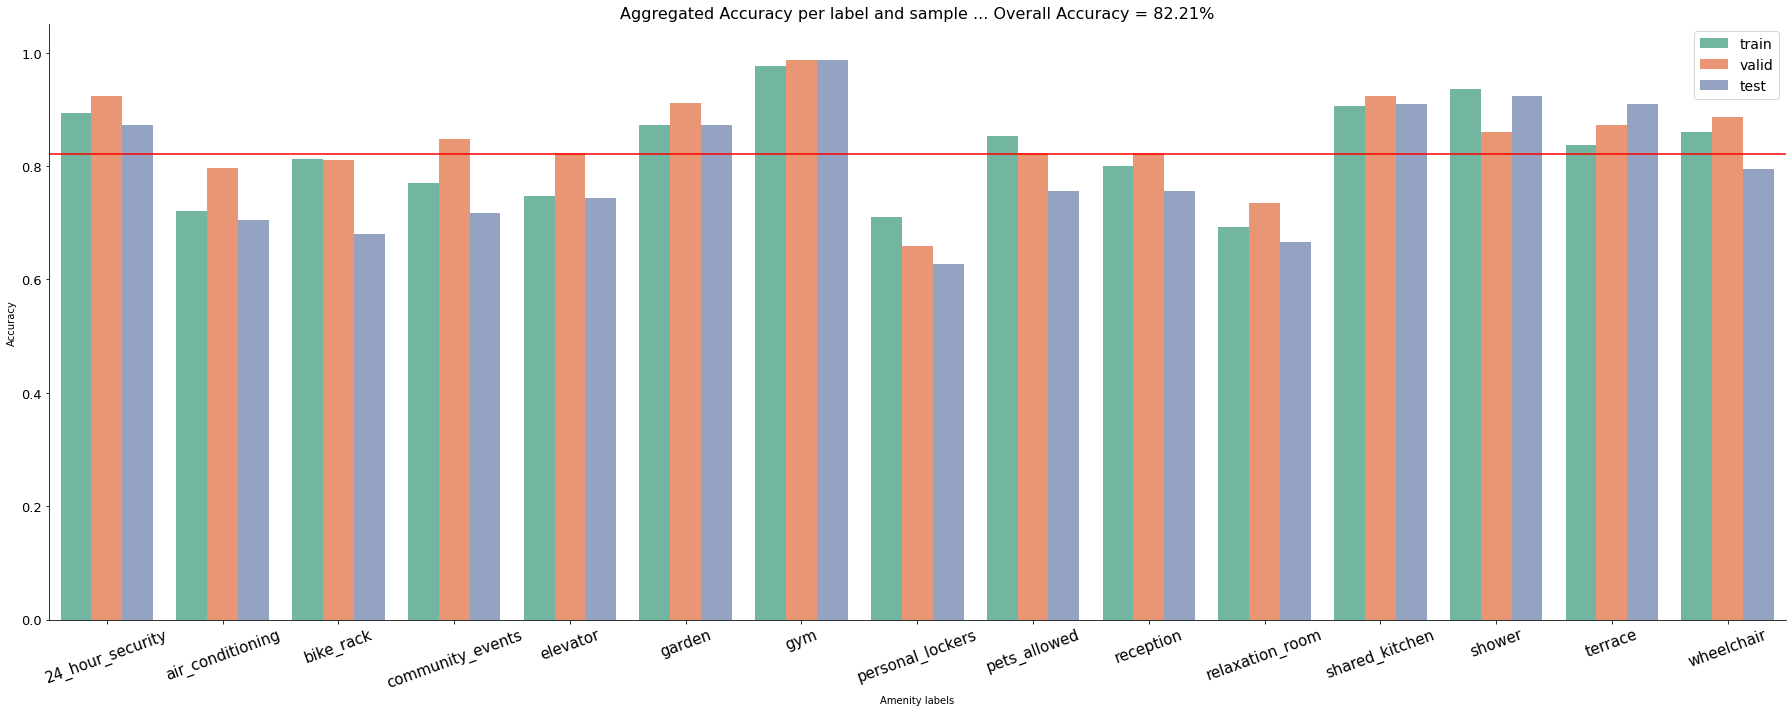

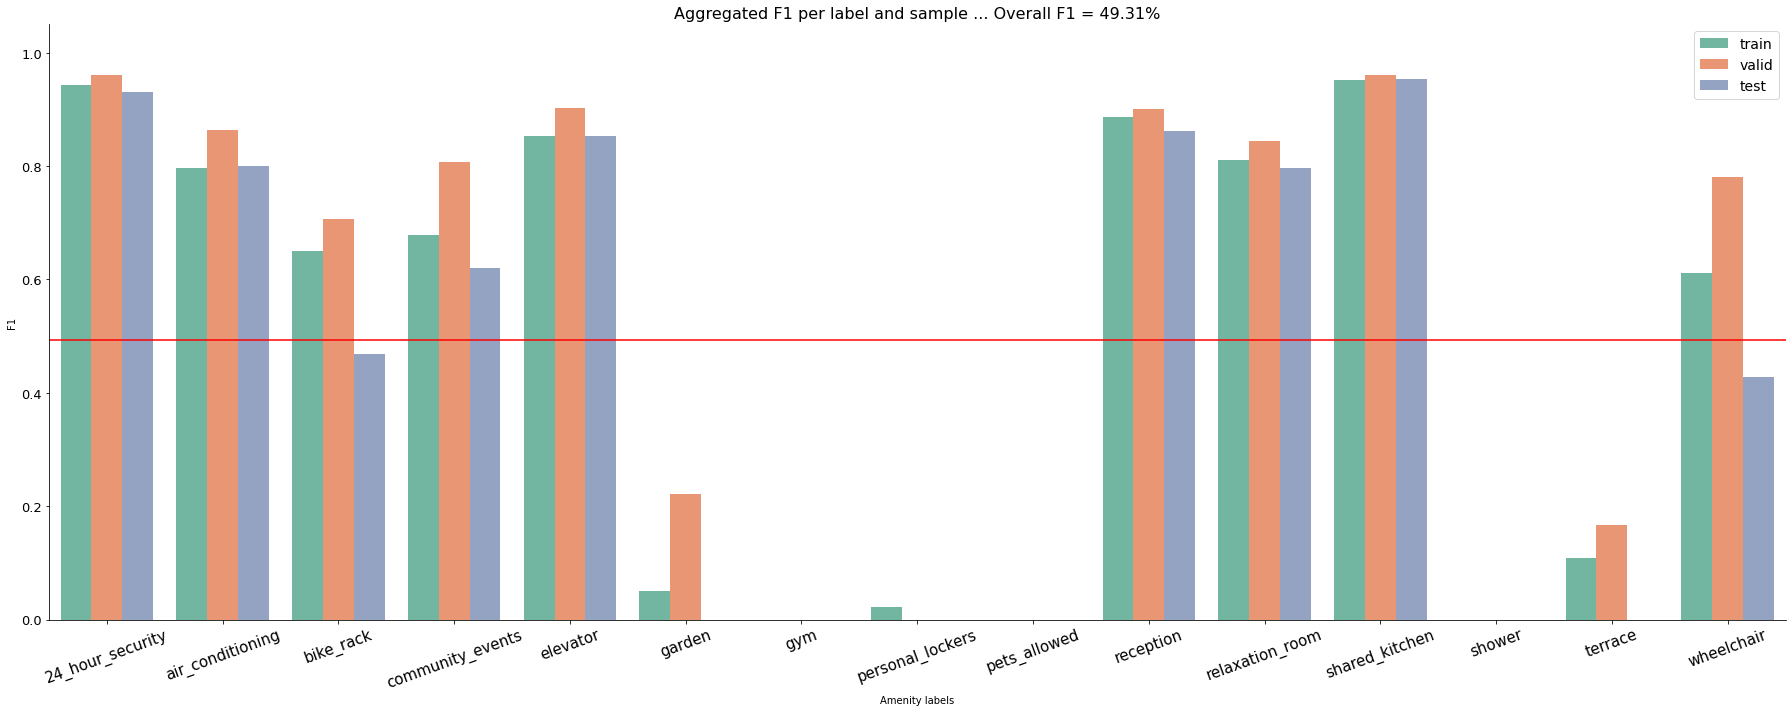

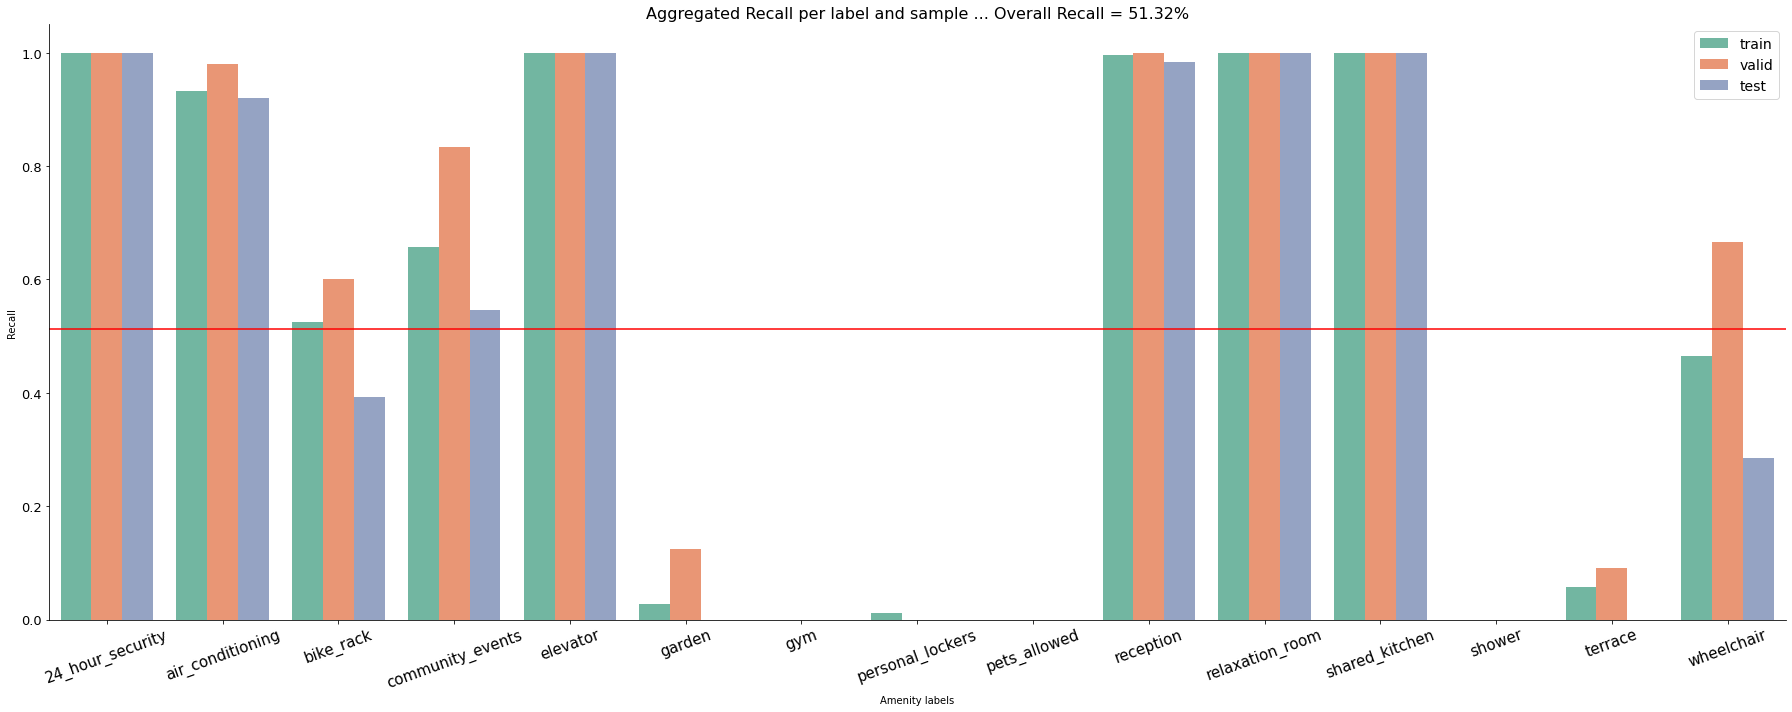

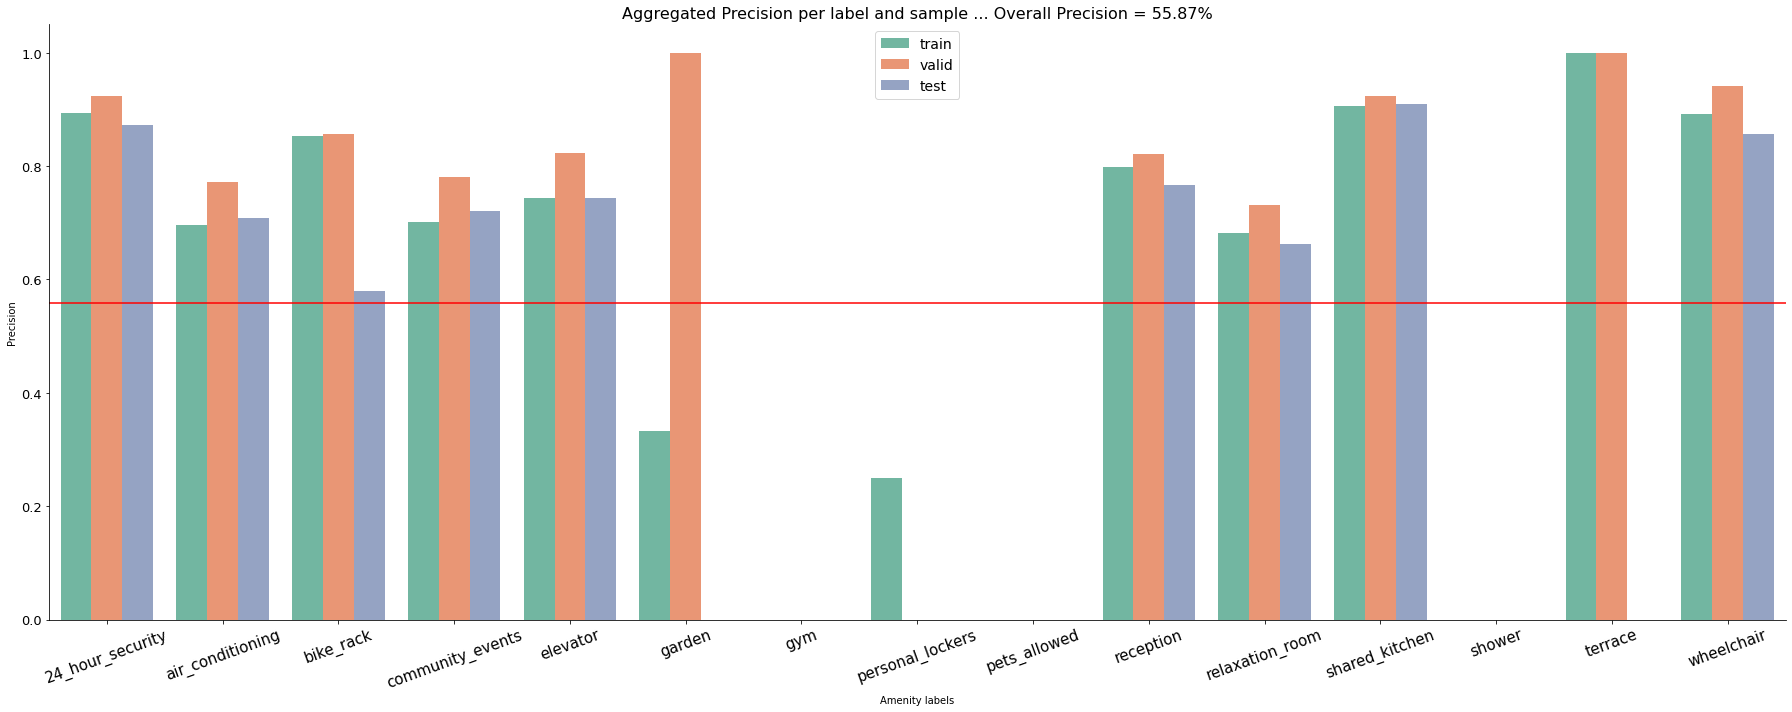

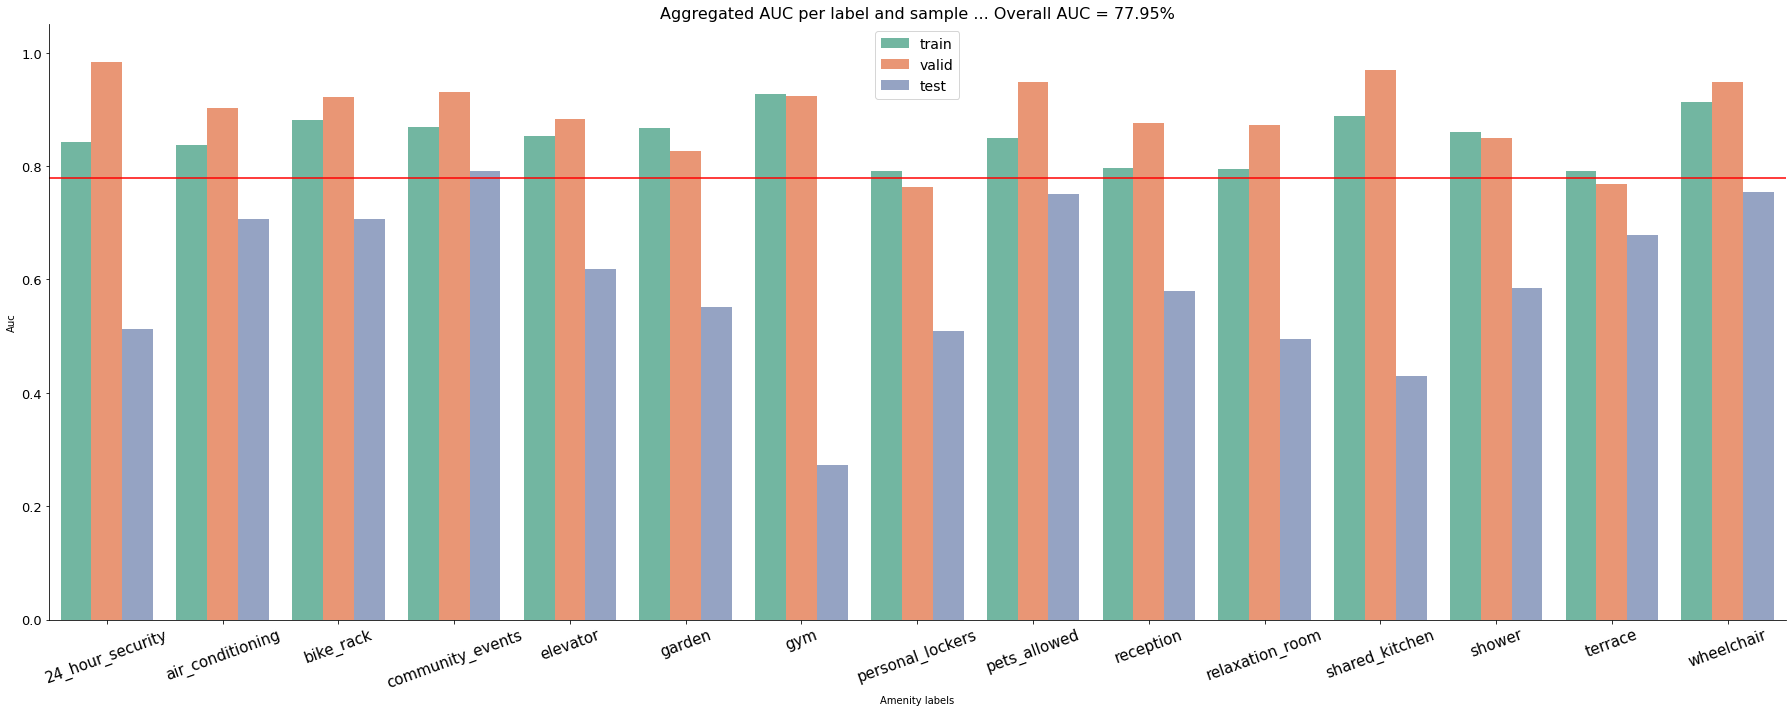

In [ ]:
plot_overall_evaluation(df_ev_overall, metrics_list, total = True)

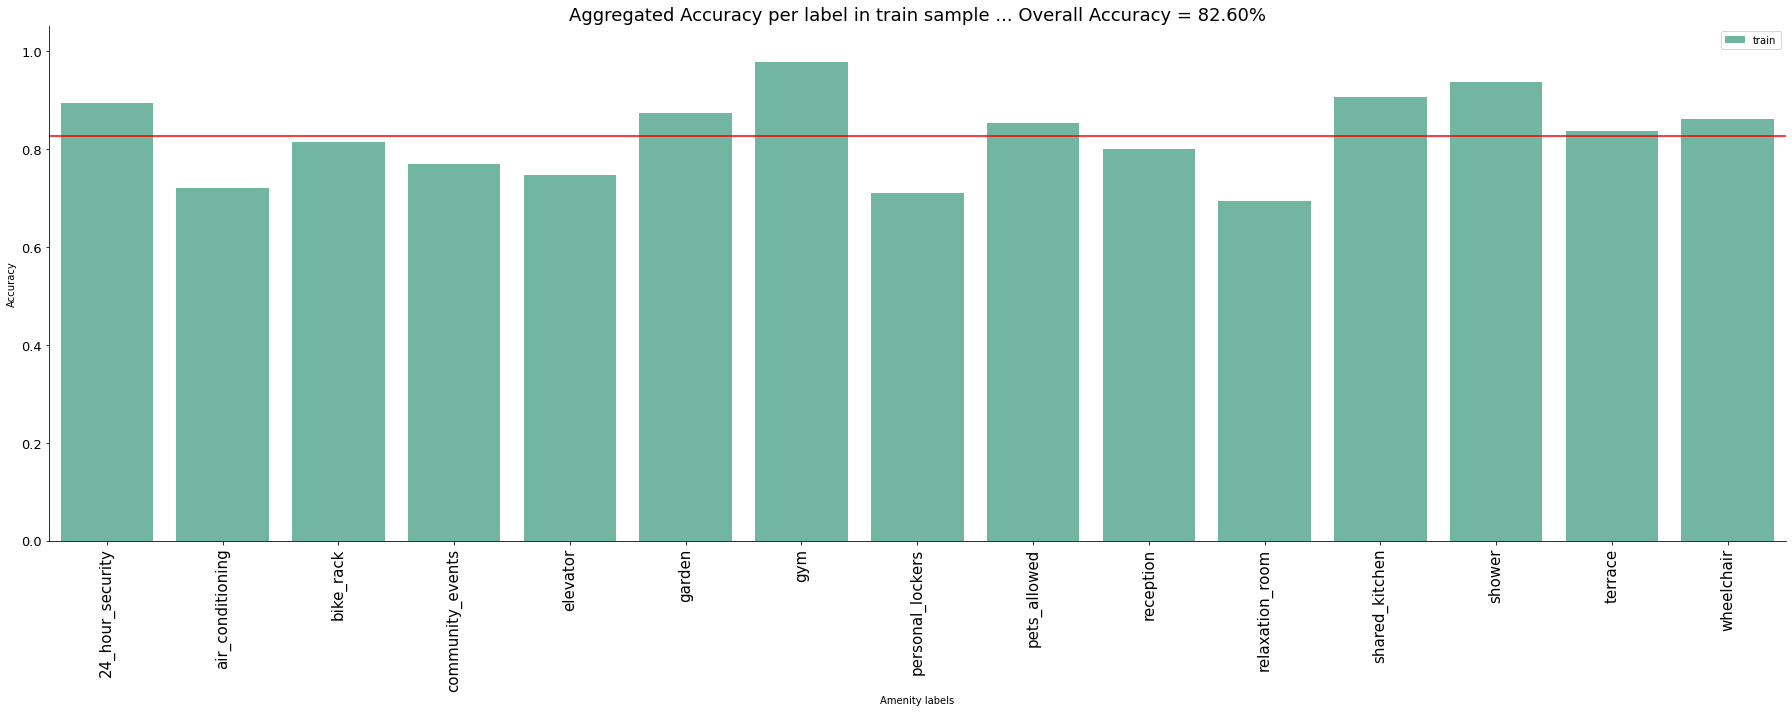

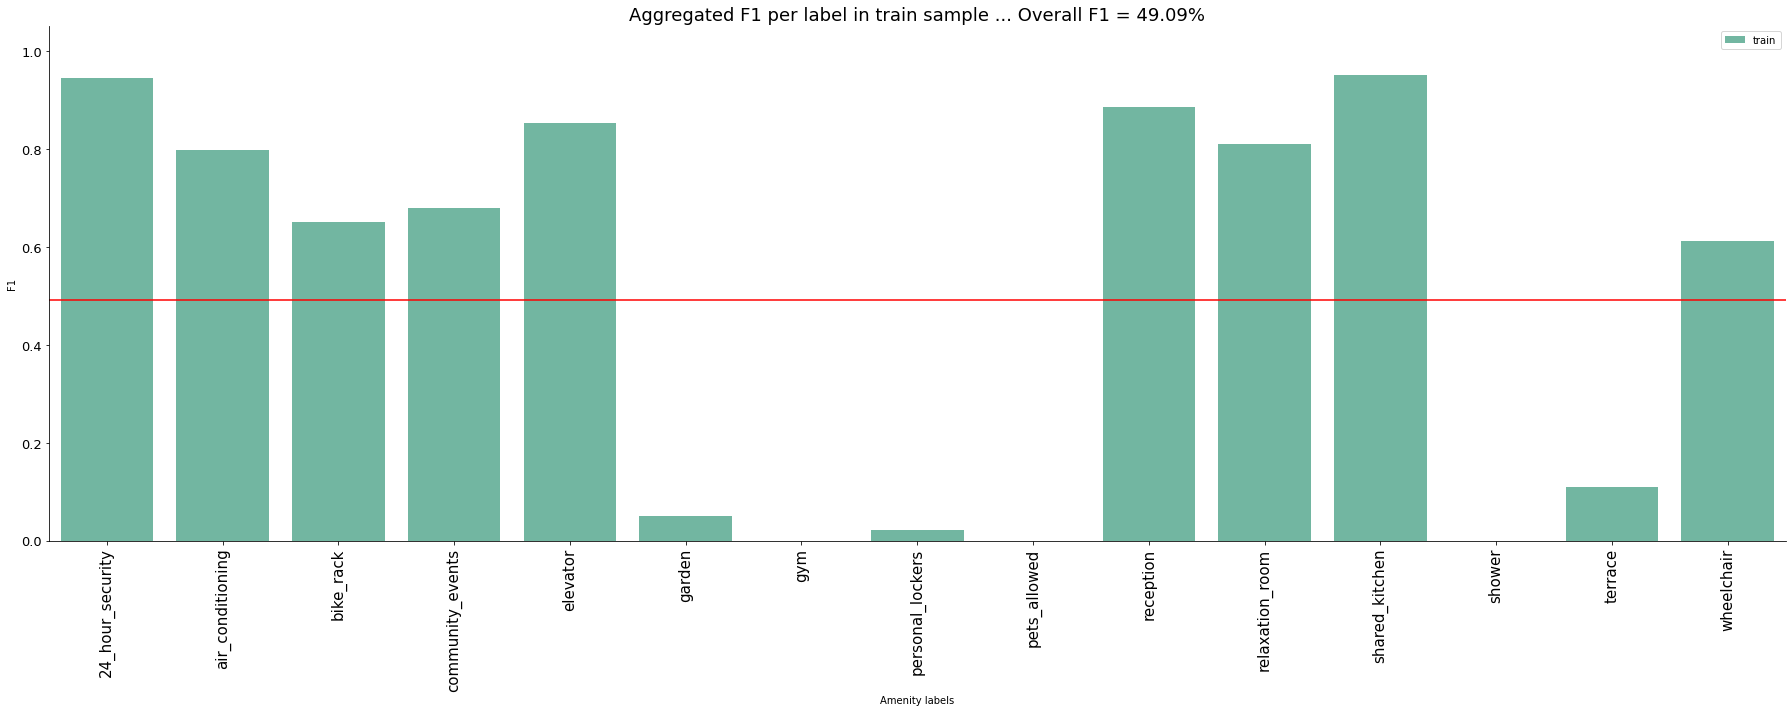

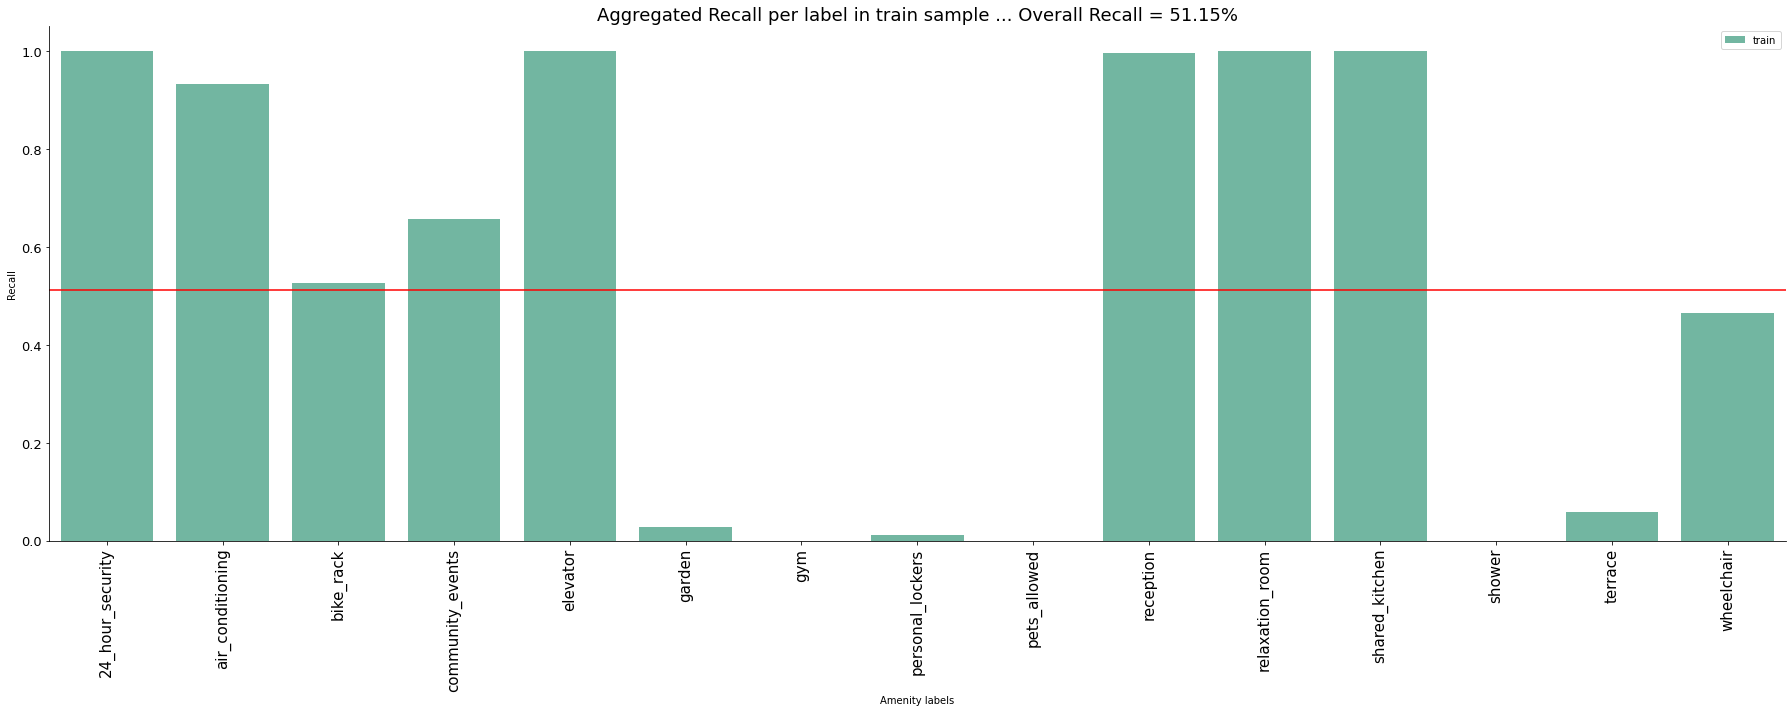

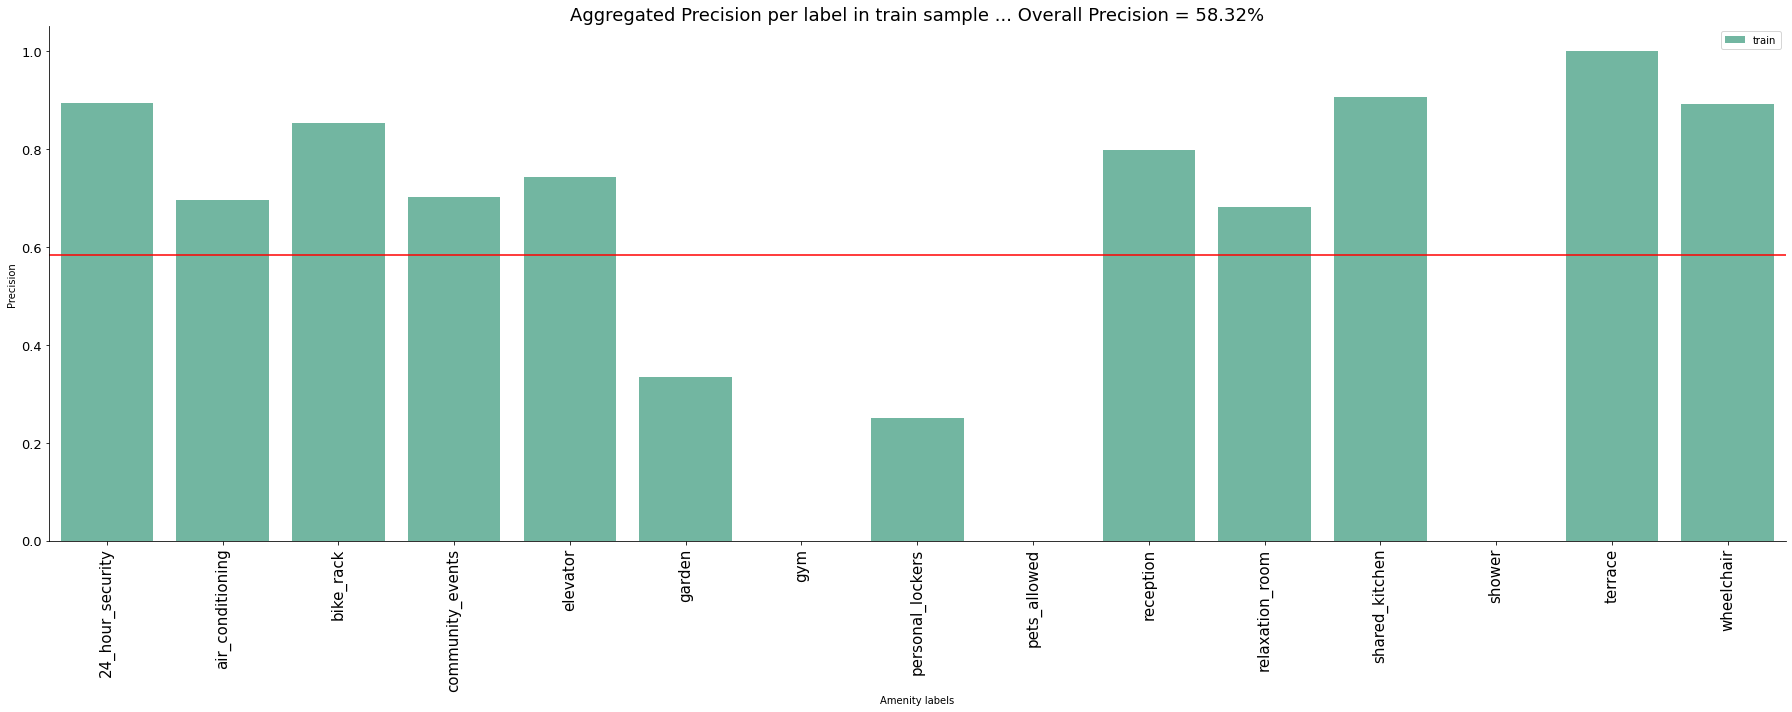

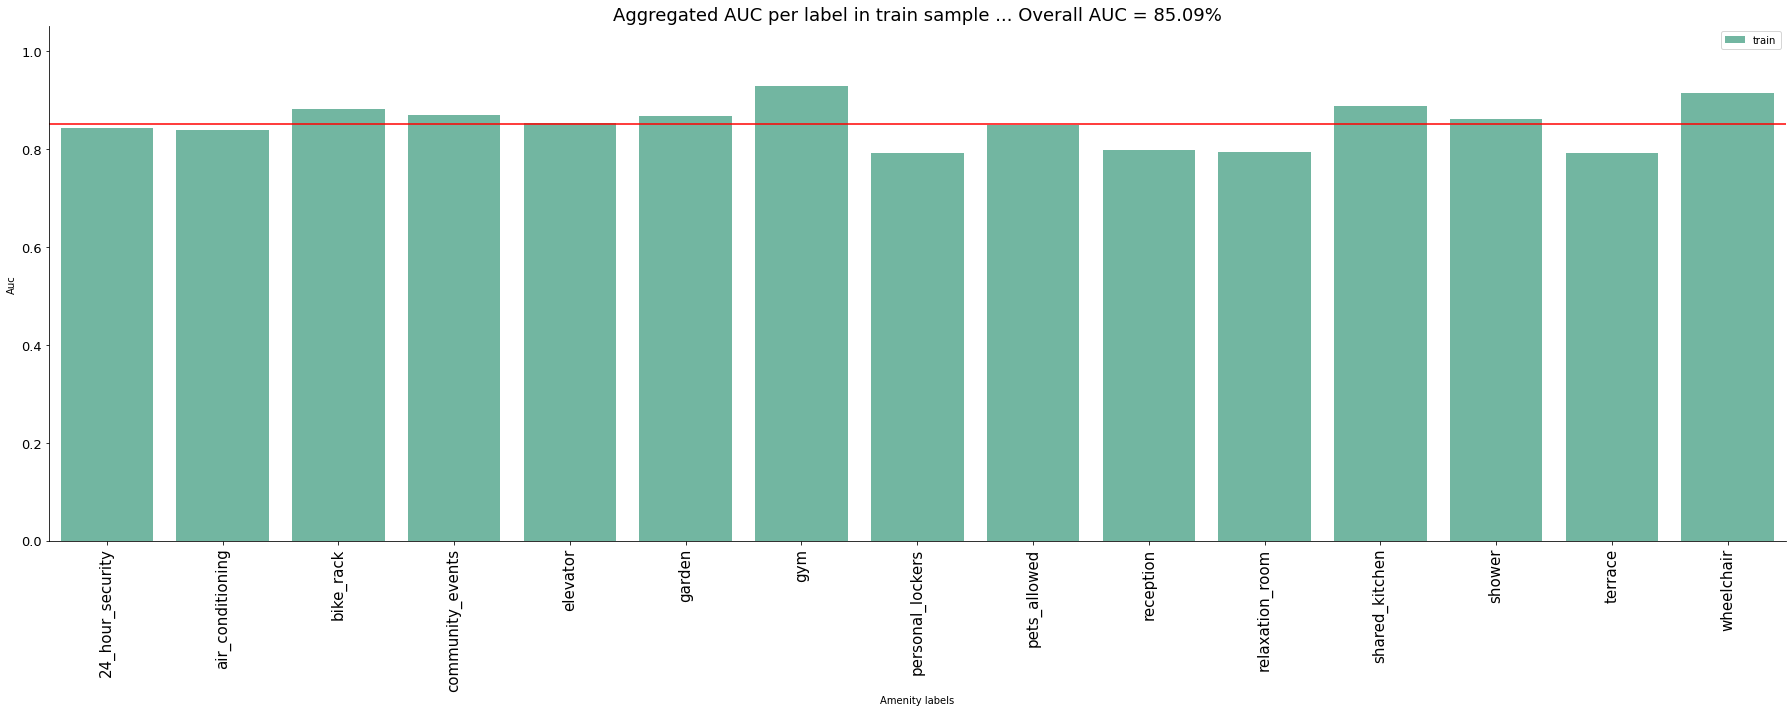

In [ ]:
plot_overall_evaluation(train_overall_ev_df, metrics_list, total = False, sample_name = 'train')

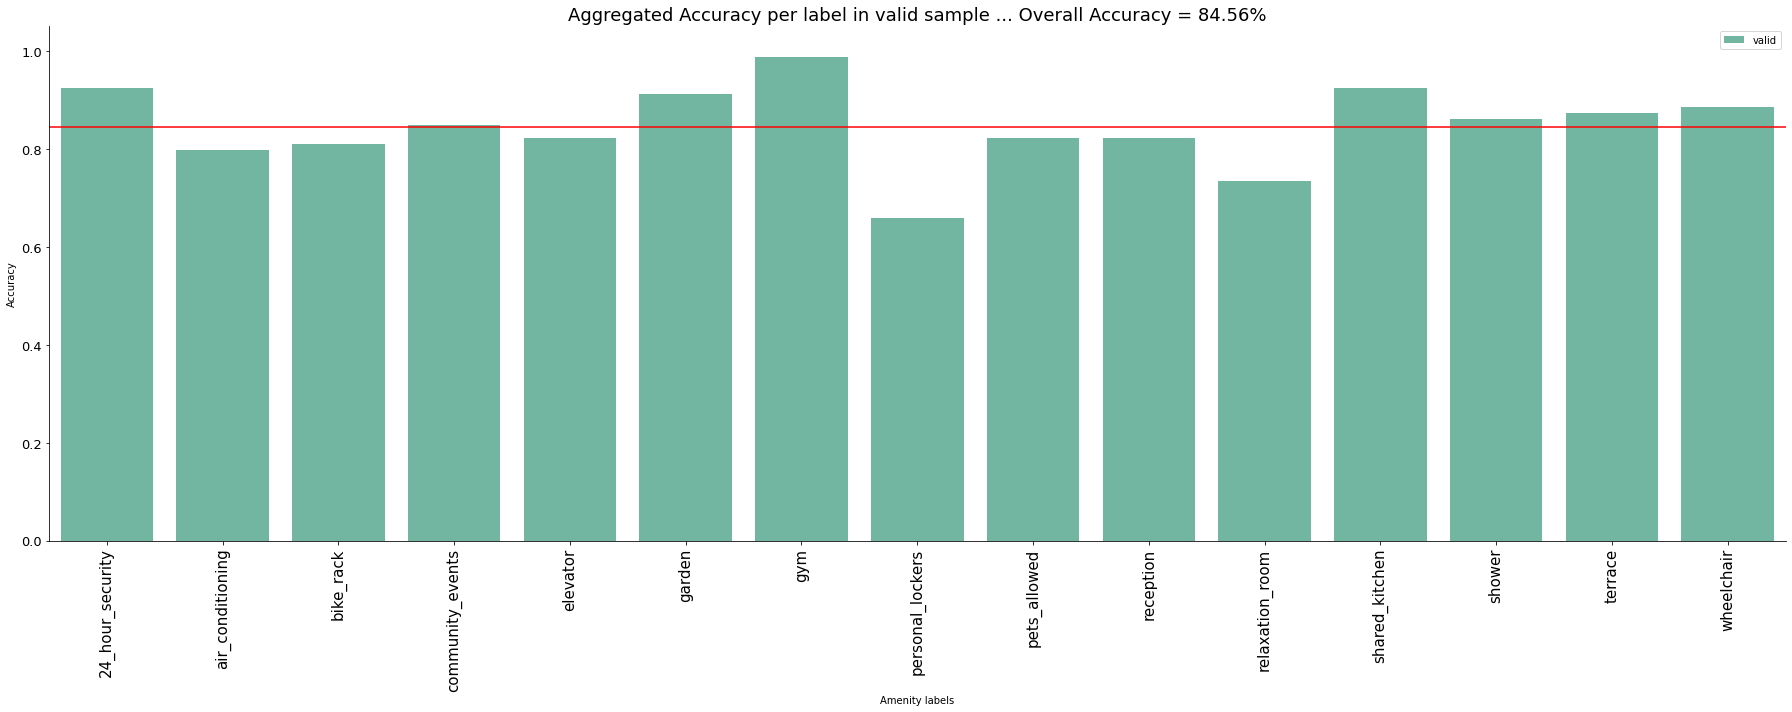

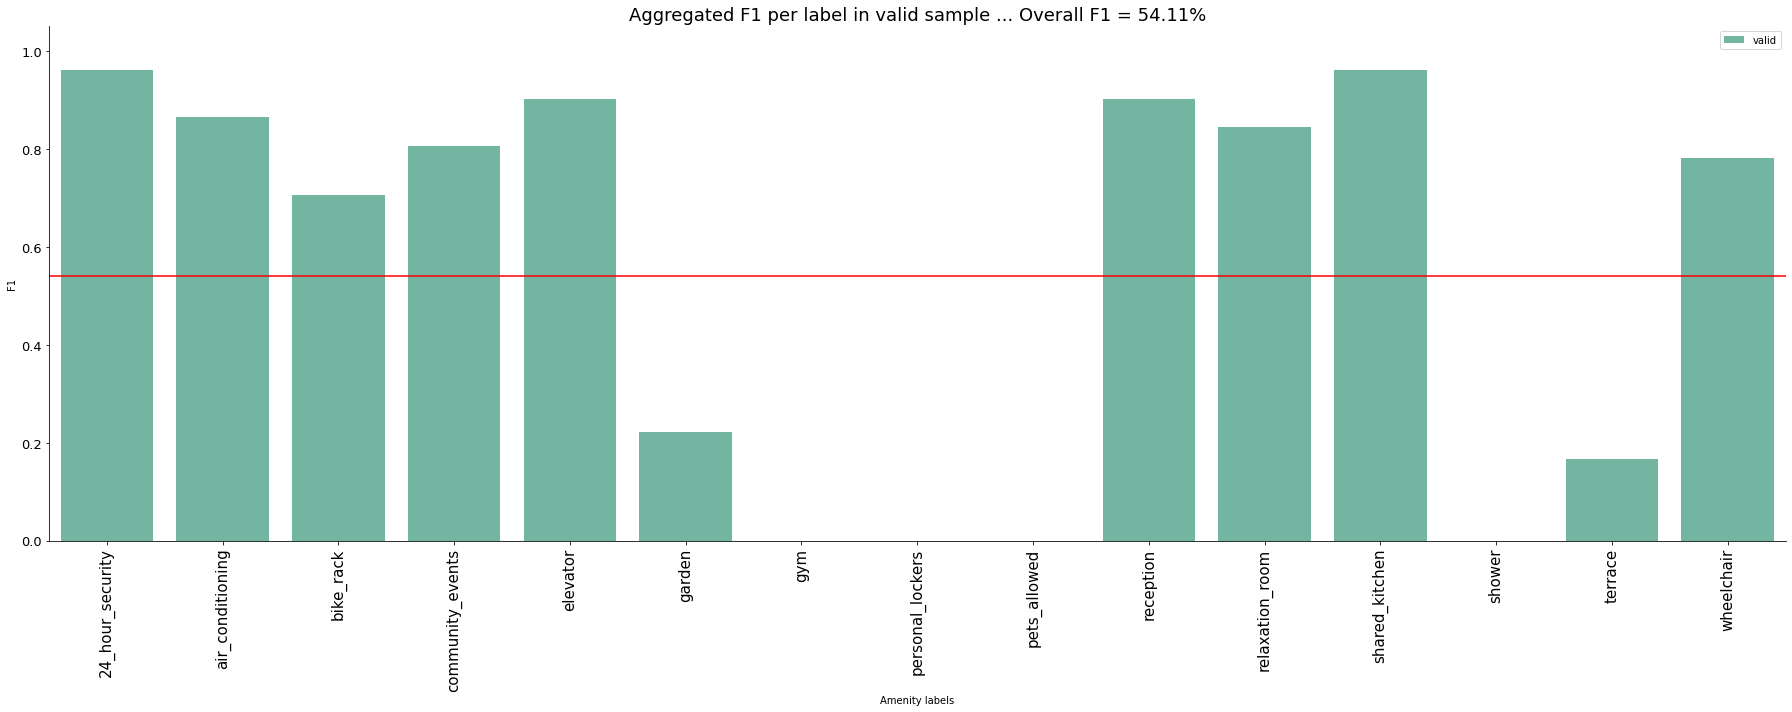

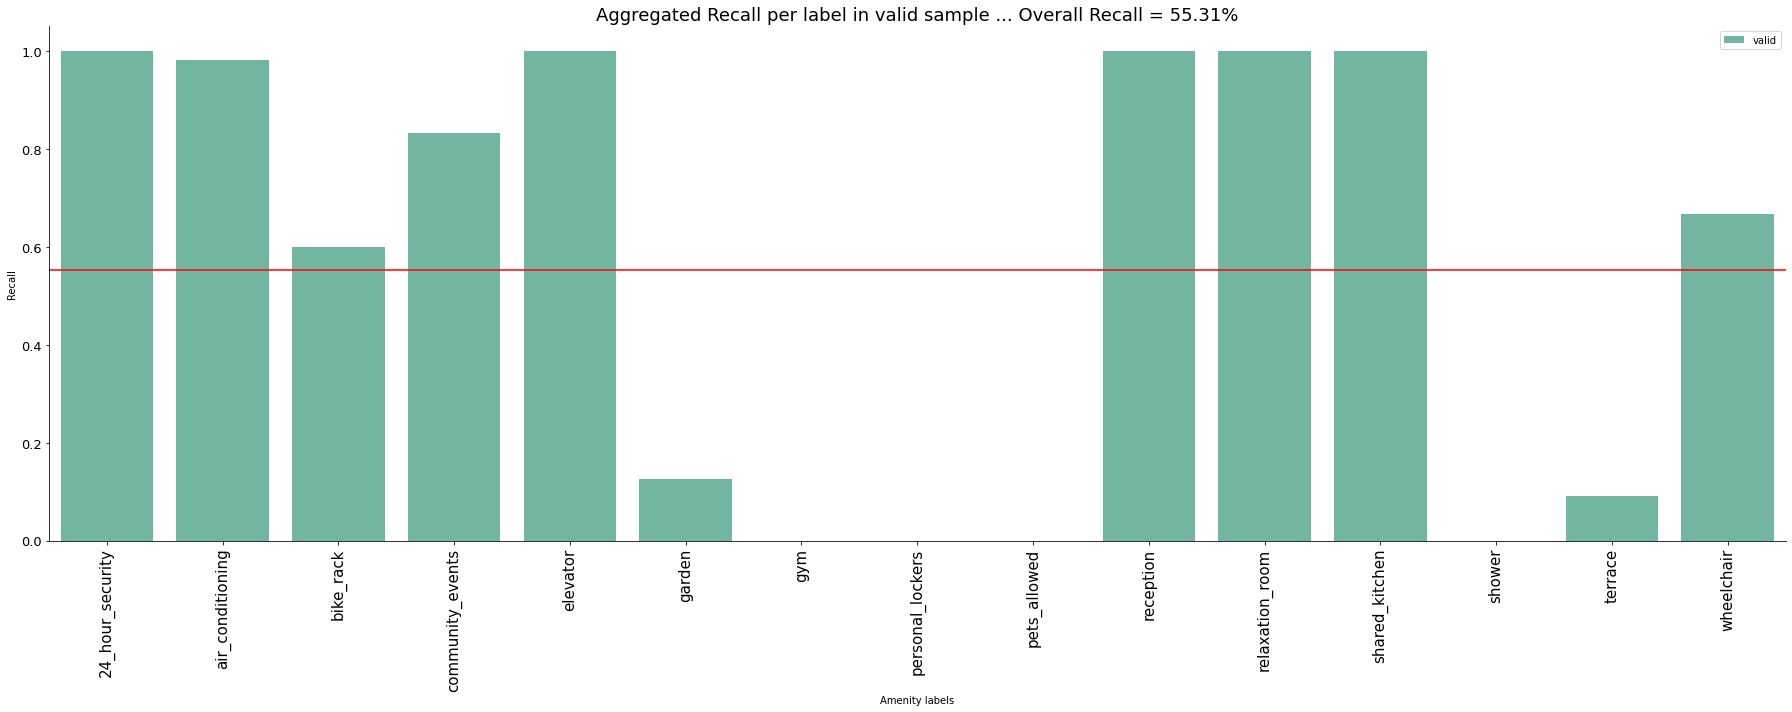

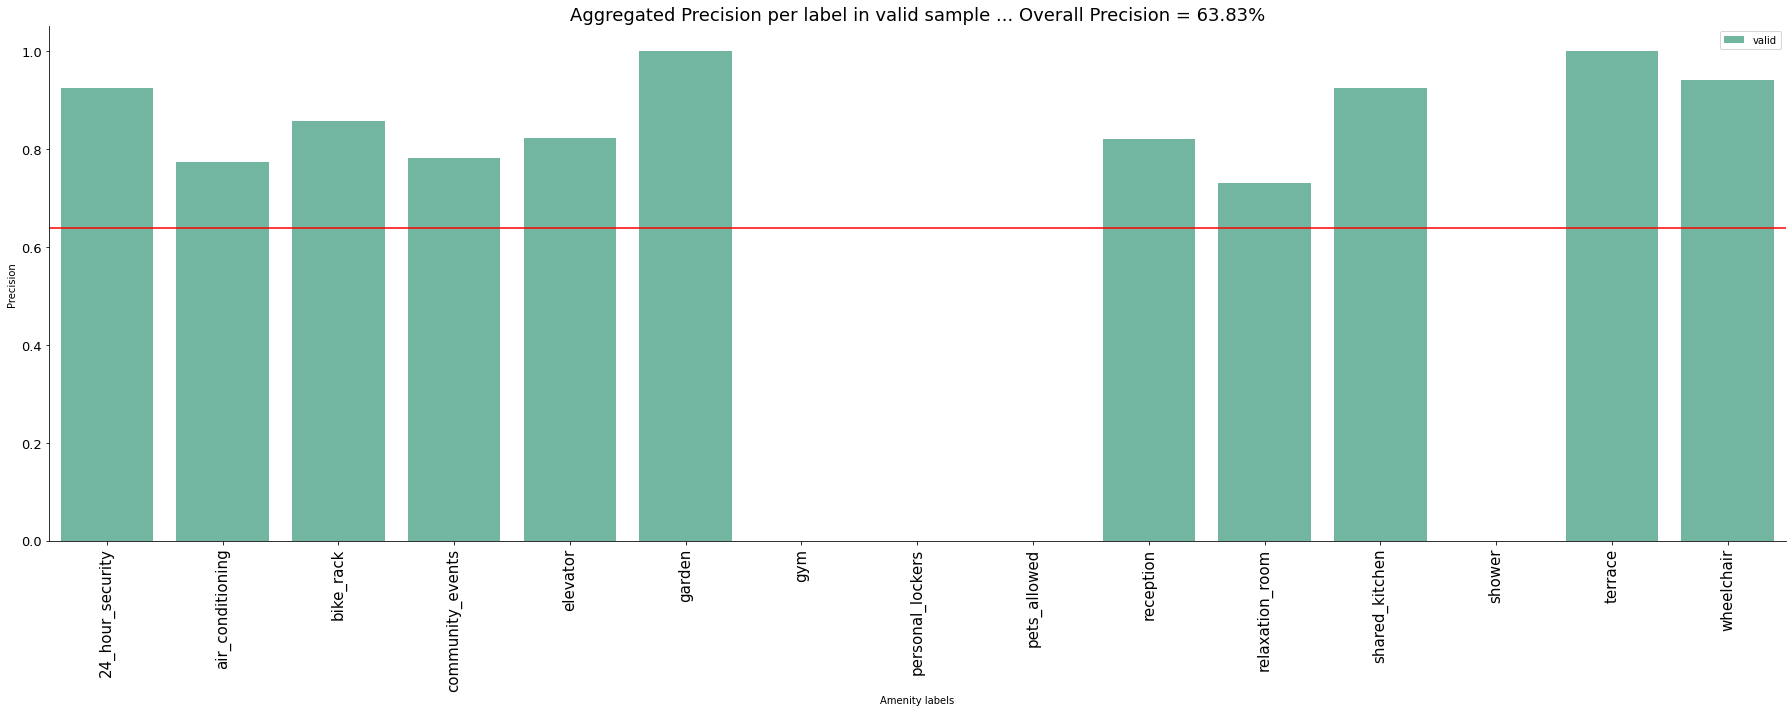

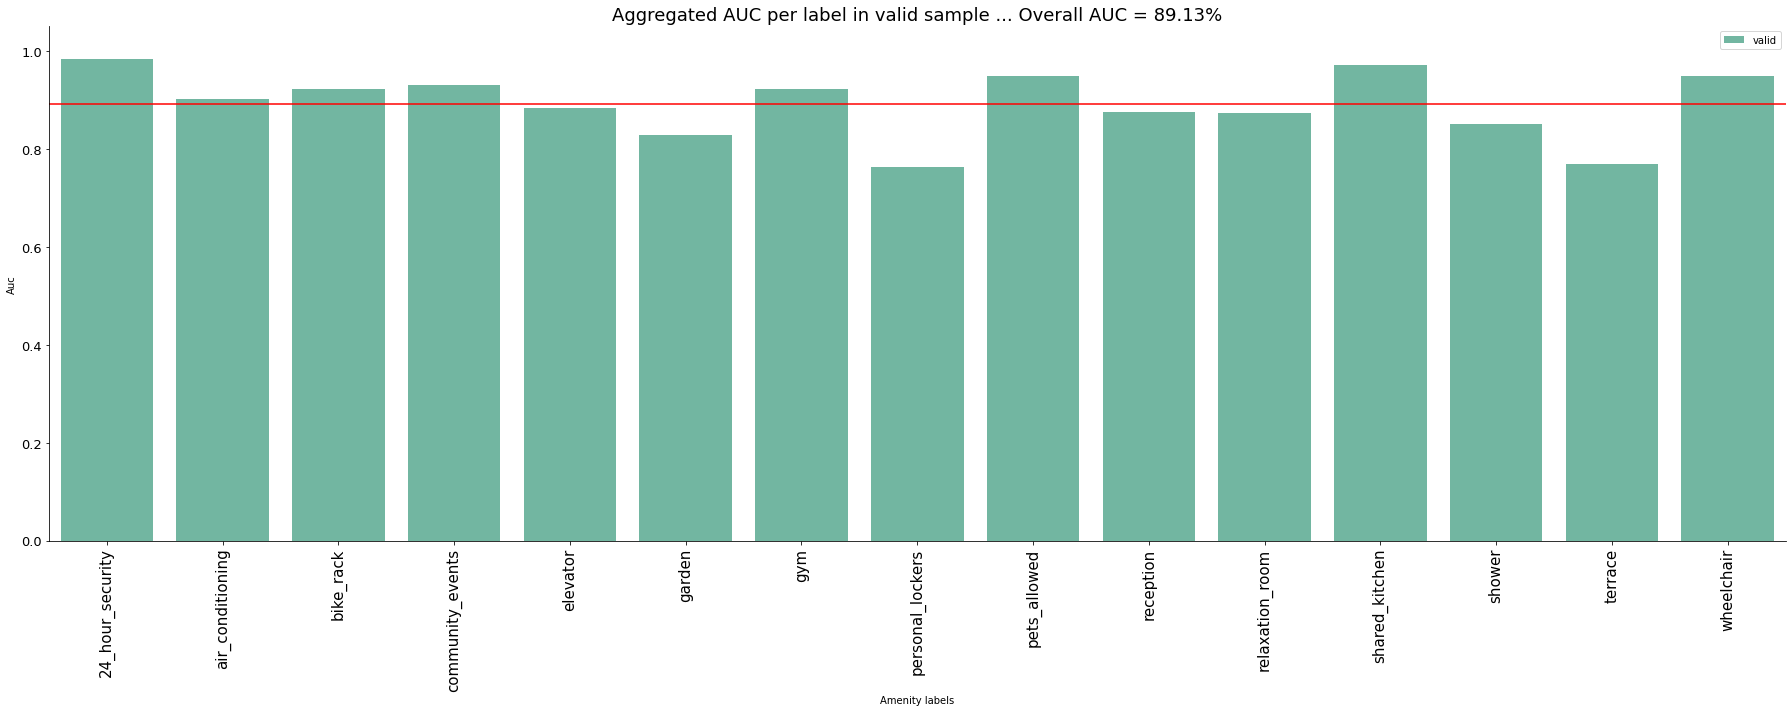

In [ ]:
plot_overall_evaluation(valid_overall_ev_df, metrics_list, total = False, sample_name = 'valid')

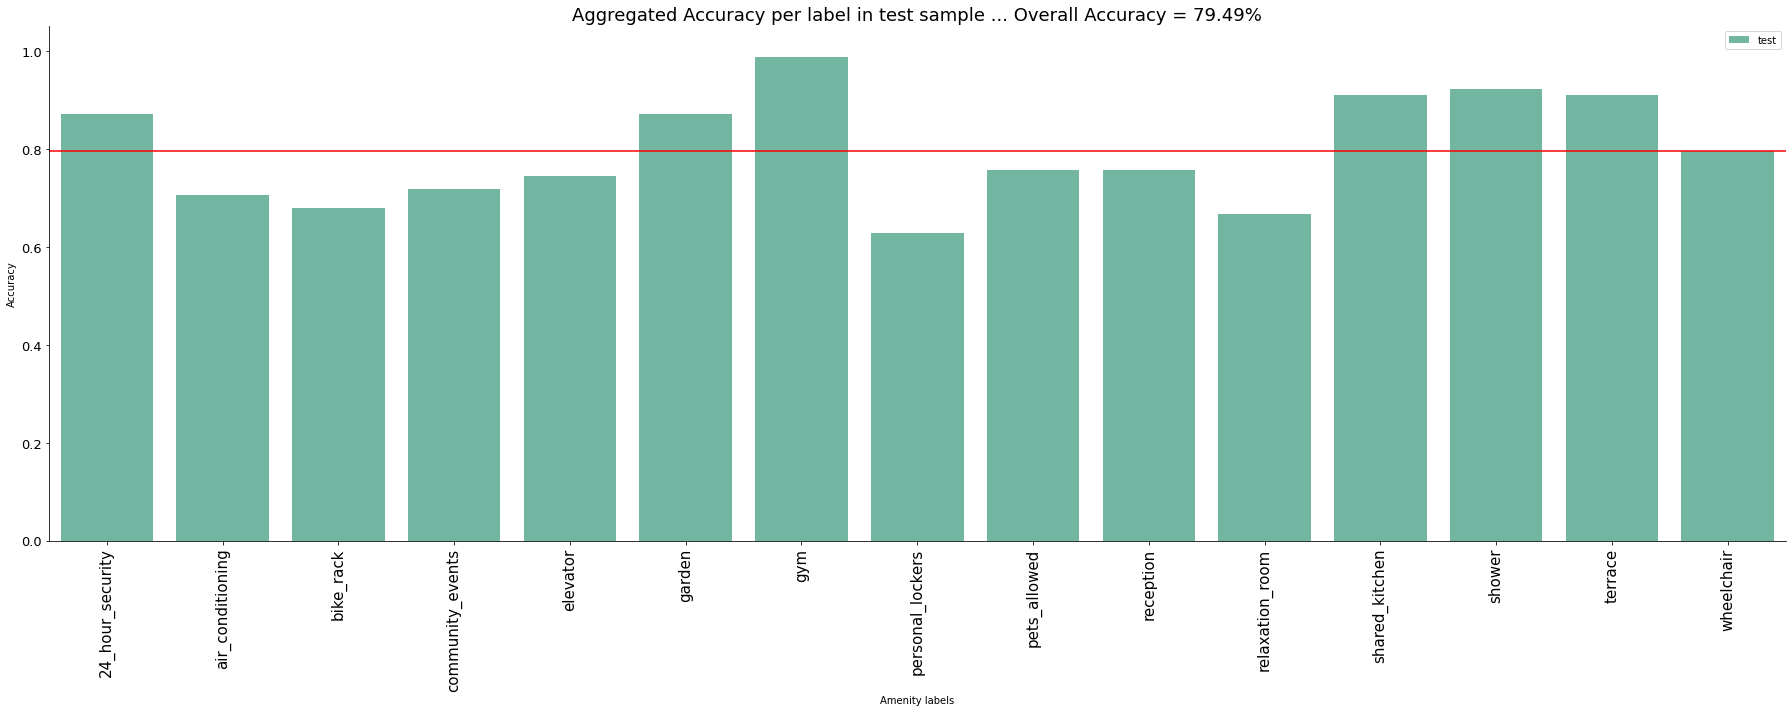

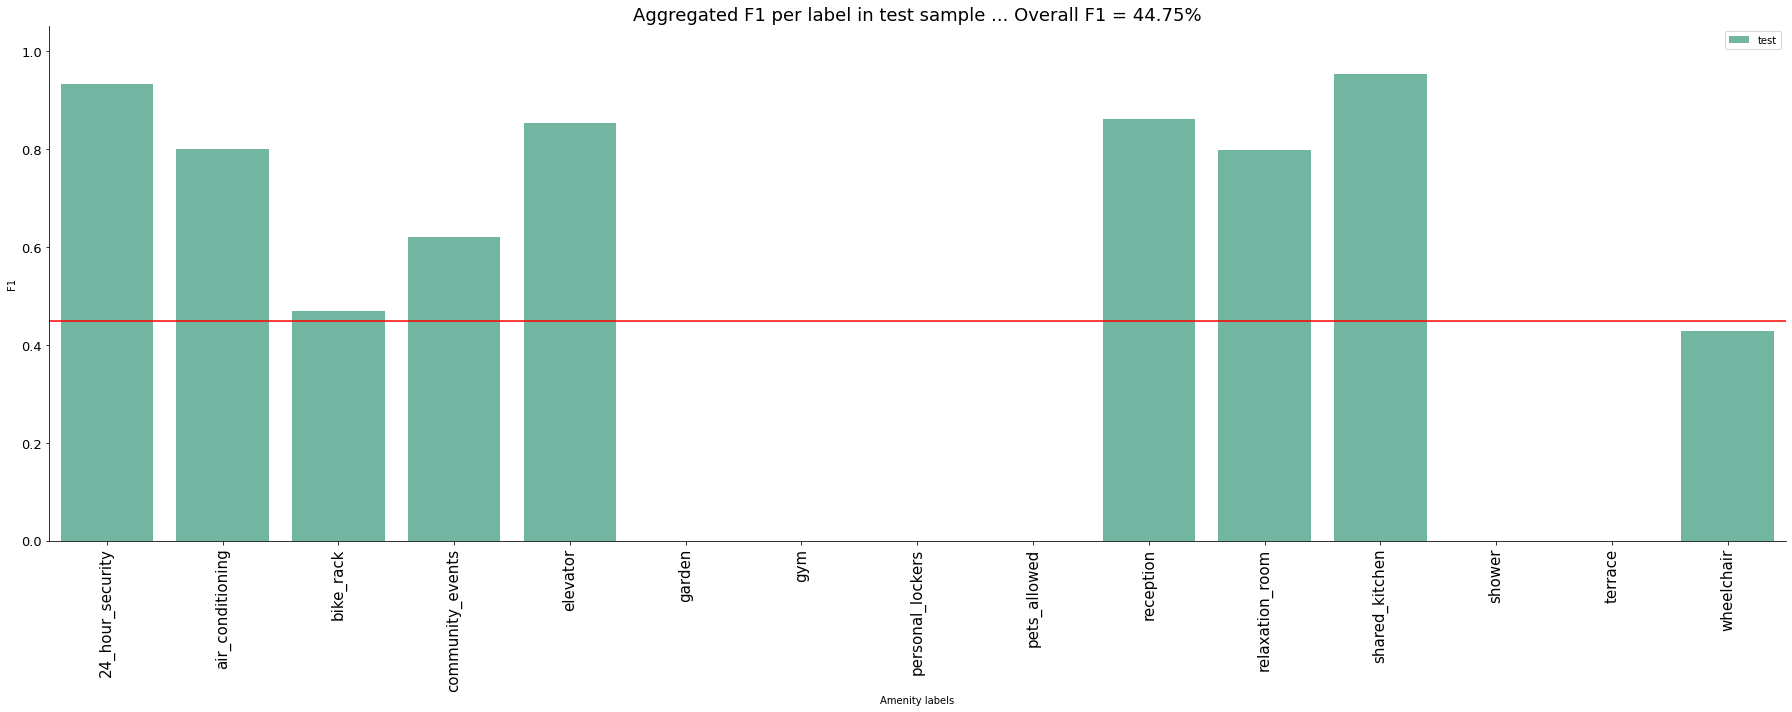

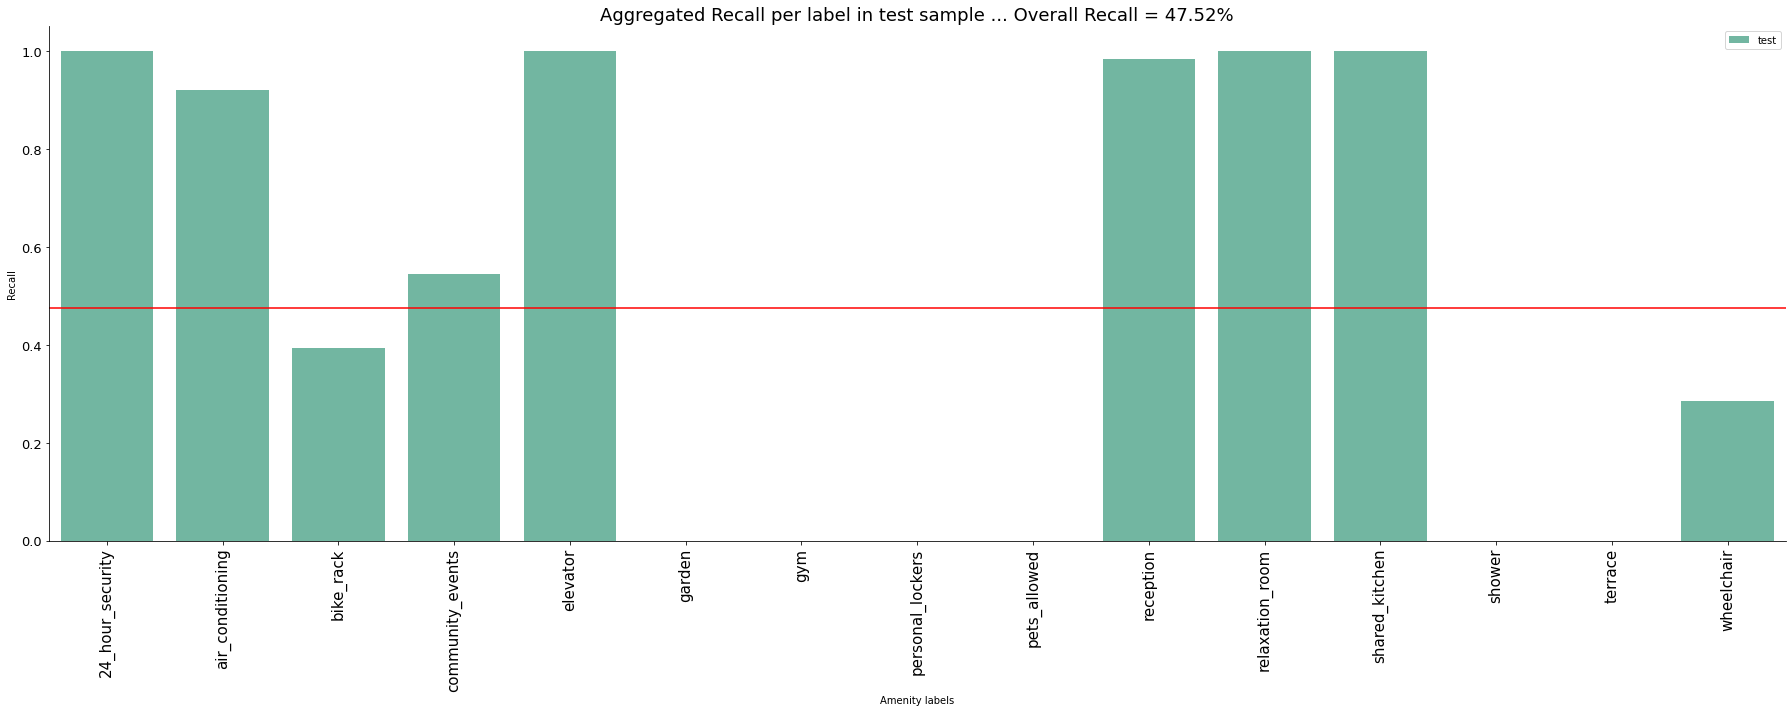

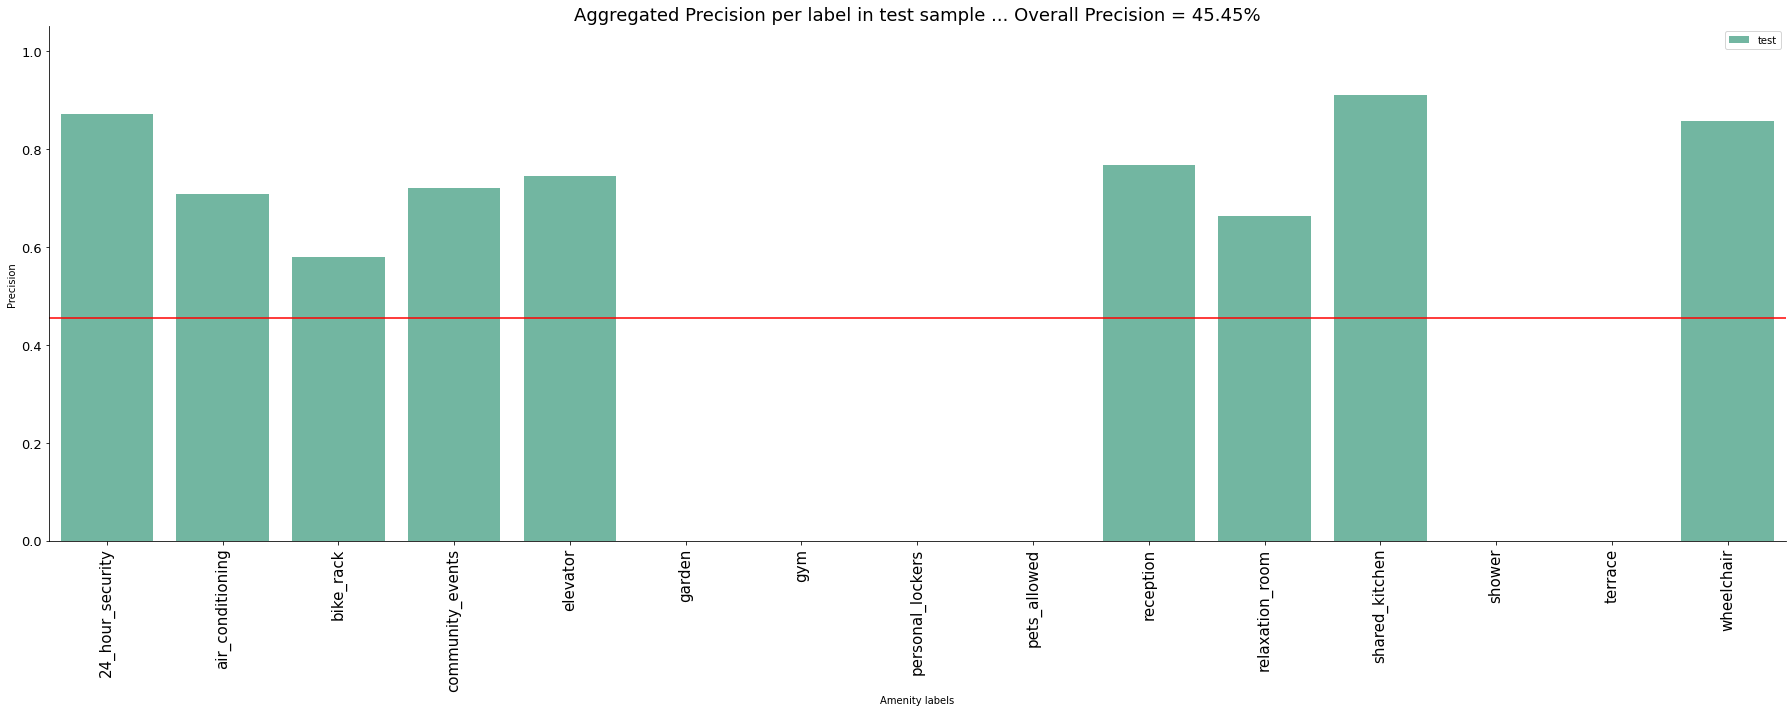

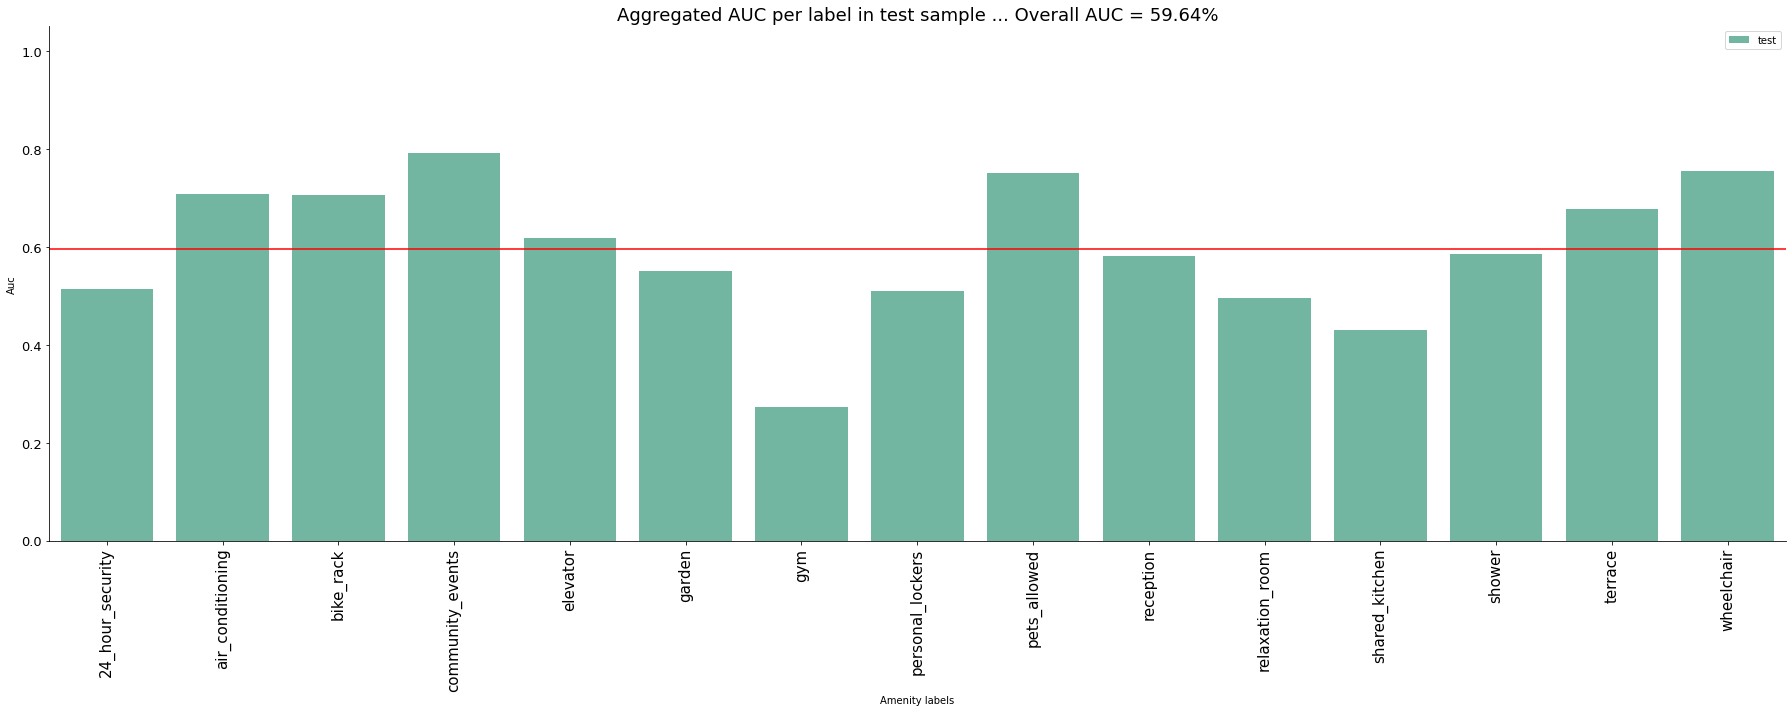

In [ ]:
plot_overall_evaluation(test_overall_ev_df, metrics_list, total = False, sample_name = 'test')

Plotting the ROC curver per amenity label

In [ ]:
def ROC_plot(predictions, df, num_pics, offices, label_names, sample_name = ''):

  #Re-definition of the sample name
  sample_name = 'whole' if sample_name == '' else sample_name

  #Data frame for storing true classes (occurrences).
  true_df = pd.DataFrame(columns = list(df.columns))
  for num, pic in zip(num_pics, offices):
    for i in range(num):
      true_row = df.query(f'location_id == {pic}')
      true_df = pd.concat((true_df, true_row))

  #Data frame for storing predicted probabilities.
  pred_df = pd.DataFrame(pd.DataFrame(predictions, columns = label_names))

  #Assigning the offices' names to each row.
  pred_df = pd.concat((true_df.reset_index()[['location_id']], pred_df), axis=1)

  #Aggregating the probabilities on the office level.
  pred_df = pred_df.groupby('location_id')[label_names].mean().reset_index()

  #Joining the predicted probabilites (probability of occurrences) with the true classes (occurrences).
  joined_df = pred_df.merge(df[df['location_id'].isin(offices)], on ='location_id', suffixes=('_pred','_true'))
  
  #Figure initialiation
  plt.figure(figsize = (13, 9))

  #List initialization for storing AUC of each amenity label.
  auc_list = []

  #For each label, plot the ROC curve and calculate the AUC score.
  for lab in label_names:
    fpr, tpr, _ = roc_curve(joined_df[f'{lab}_true'], joined_df[f'{lab}_pred'])
    auc = roc_auc_score(joined_df[f'{lab}_true'], joined_df[f'{lab}_pred'])
    auc_list.append(auc)
    plt.plot(fpr,tpr,label=f"{lab}'s AUC = {auc*100:.2f}%",  linewidth=1)

  #Plotting a baseline
  plt.plot([0, 1], [0, 1], 'r--',  linewidth=1)
  plt.ylabel('True Positive Rate', size = 10)
  plt.xlabel('False Positive Rate', size = 10)
  
  #Calculating an average AUC of all the amenities' AUC's.
  avg_auc = np.mean(auc_list) 
  plt.title(f'ROC curves per amenity label on {sample_name} sample ... average AUC = {avg_auc*100:.2f}%', size = 15)

  plt.legend(bbox_to_anchor=(-0.07, 1.0), shadow = True, fontsize = 13)
  plt.grid()
  
  axes = plt.gca()
  axes.spines['top'].set_visible(False)
  axes.spines['right'].set_visible(False)
  
  plt.tight_layout()

  #Exporting the plot
  if sample_name == 'whole':
    plt.savefig("plots/Evaluation/Whole sample/All_AUC_per_label.png")

  else:
    #Folder name definition
    if sample_name == 'train':
      folder_name = 'Training sample'
    elif sample_name == 'valid':
      folder_name = 'Validation sample'
    elif sample_name == 'test':
        folder_name = 'Test sample'
    
    #Exporting the plot
    path_name = f"plots/Evaluation/{folder_name}/"
    plot_name = f"{str.capitalize(sample_name)}_AUC_per_label_name.png"
    plt.savefig(os.path.join(path_name, plot_name))

  plt.show()

In [ ]:
all_predictions = np.concatenate((train_all_predictions, valid_all_predictions, test_all_predictions))
all_num_pics = train_num_pics + valid_num_pics + test_num_pics
all_offices = np.concatenate((train_offices, valid_offices, test_offices))

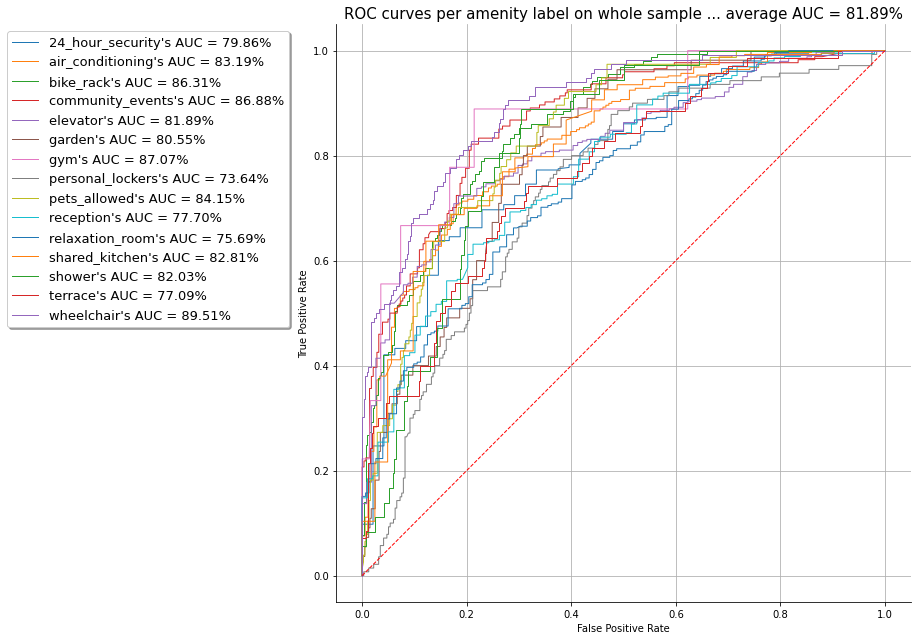

In [ ]:
ROC_plot(all_predictions, df, all_num_pics, all_offices, label_names)

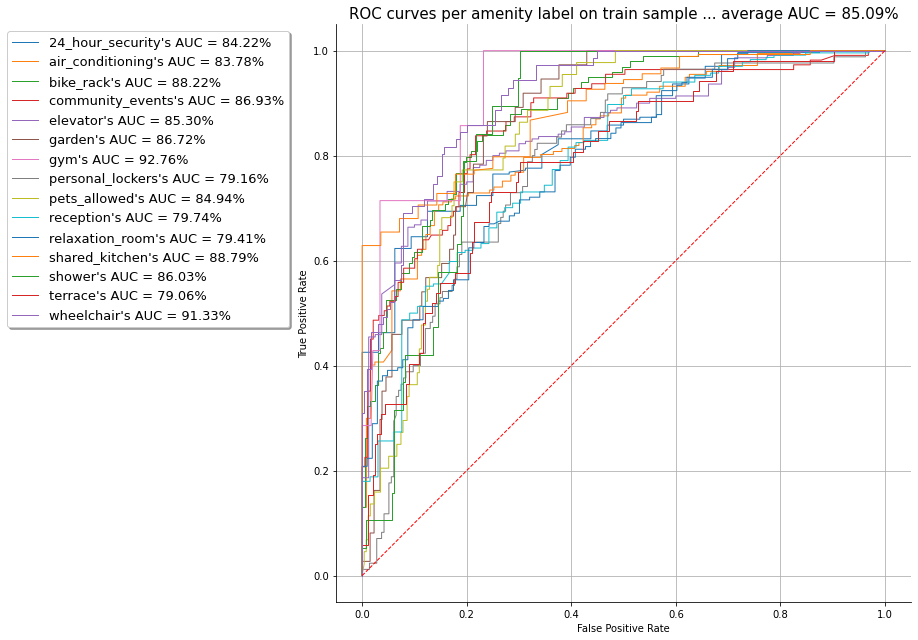

In [ ]:
ROC_plot(train_all_predictions, df, train_num_pics, train_offices, label_names, sample_name = 'train')

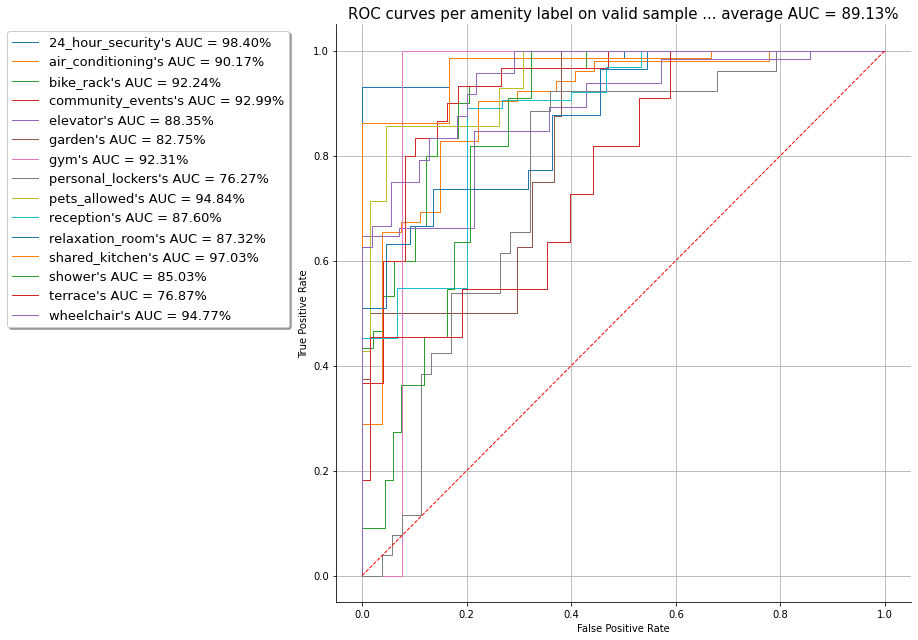

In [ ]:
ROC_plot(valid_all_predictions, df, valid_num_pics, valid_offices, label_names, sample_name = 'valid')

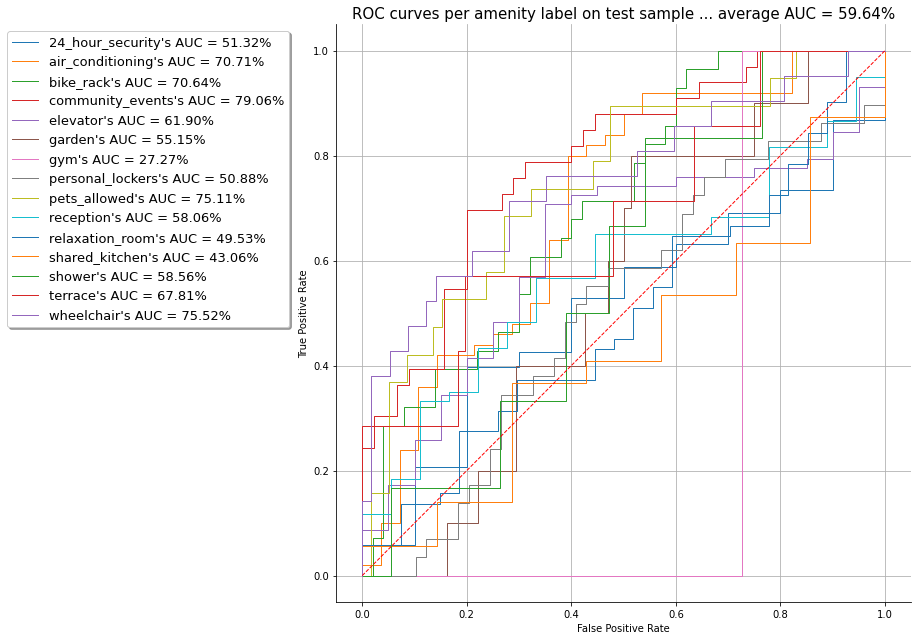

In [ ]:
ROC_plot(test_all_predictions, df, test_num_pics, test_offices, label_names, sample_name = 'test')

##**Amenities' list generator**
- Based on predicted classes (occurrences), we predict a list of amenities which can be used for amenities' listing text generator in the further NLP dvelopment within the real-estate advertisement.

Data frame for storing the list of predicted amenities' occurrences per each office.

In [ ]:
def preds_prop_listing(predictions, df, num_pics, offices, label_names):

    #Data frame for storing true classes.
    true_df = pd.DataFrame(columns = list(df.columns))
    for num, pic in zip(num_pics, offices):
        for i in range(num):
            true_row = df.query(f'location_id == {pic}')
            true_df = pd.concat((true_df, true_row))
    
    #Dataframe for storing predicted probabilitiess. 
    pred_df = pd.DataFrame(pd.DataFrame(predictions, columns = [f'{c}_prob' for c in label_names]))
    
    #Assinging the offices' names to each row.
    joined_df = pd.concat((true_df.reset_index()[['location_id']], pred_df), axis=1)

    #Aggregating the probabilities on the office level.
    joined_df = joined_df.groupby('location_id')[[f'{c}_prob' for c in label_names]].mean().reset_index()

    #Accessing the predicted classes (occurrences) based on the aggregated probabilites (per each amenity label).
    for c in label_names:
      joined_df[c] = joined_df[f'{c}_prob'].apply(lambda x: 1 if x > 0.5 else 0)

    #Filtering only the predicted classes' columns (excluding the probabilities' columns).
    pred_class_df = joined_df[[i for i in joined_df.columns if i.split('_')[-1] != 'prob']]
    
    #List containing 1's and 0's indicating predicted occurrences of amenities for each office.
      #1, if the occurrences of given amenity was predicted, else 0.
    pred_class_df['class_indicators'] = pred_class_df.drop('location_id', axis = 1).values.tolist()

    #List for storing the predicted amenities' names for each office.
    row_names_list = []

    #For each office, find the amenities' names whose occurrences have been predicted.
    for _, row in pred_class_df.iterrows():
  
      name_list = [] #list for storing predicted amenities' names for given office.

      #For each predicted occurrence indicator and amenity name,
        #Find the ones whose occurrences have been predicted and,
        #Attach them to the list storing the predicted amenity names for given office.
      for num, name in zip(row['class_indicators'], label_names):
        if num == 1:
          name_list.append(name)

      #Attach the list of predicted amenities' names for given office 
        #To the list storing the predicted amenities' names for each office.
      row_names_list.append(str([','.join(name_list)]))

    #Assigning the list to the data frame.
    pred_class_df['label_names'] = [i.replace('[','').replace(']','').replace("'",'') for i in row_names_list]

    return pred_class_df[['location_id', 'label_names']]

In [ ]:
train_preds_listing = preds_prop_listing(train_all_predictions, df, train_num_pics, train_offices, label_names)

In [ ]:
valid_preds_listing = preds_prop_listing(valid_all_predictions, df, valid_num_pics, valid_offices, label_names)

In [ ]:
test_preds_listing = preds_prop_listing(test_all_predictions, df, test_num_pics, test_offices, label_names)

In [ ]:
display(train_preds_listing)

,location_id,label_names
0,2862,"24_hour_security,community_events,elevator,reception,relaxation_room,shared_kitchen"
1,6617,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,reception,relaxation_room,shared_kitchen"
2,6624,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
3,11971,"24_hour_security,elevator,reception,relaxation_room,shared_kitchen"
4,12218,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,reception,relaxation_room,shared_kitchen,wheelchair"
...,...,...
295,89935,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,reception,relaxation_room,shared_kitchen"
296,103037,"24_hour_security,elevator,reception,relaxation_room,shared_kitchen"
297,103051,"24_hour_security,elevator,reception,relaxation_room,shared_kitchen"
298,105300,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,reception,relaxation_room,shared_kitchen,wheelchair"


In [ ]:
display(valid_preds_listing)

,location_id,label_names
0,11986,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,reception,relaxation_room,shared_kitchen,wheelchair"
1,12217,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,reception,relaxation_room,shared_kitchen,wheelchair"
2,12328,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
3,13646,"24_hour_security,elevator,reception,relaxation_room,shared_kitchen"
4,14006,"24_hour_security,elevator,reception,relaxation_room,shared_kitchen"
...,...,...
74,74924,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
75,83402,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
76,102908,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
77,105287,"24_hour_security,air_conditioning,community_events,elevator,reception,relaxation_room,shared_kitchen"


In [ ]:
display(test_preds_listing)

,location_id,label_names
0,6631,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
1,12329,"24_hour_security,elevator,reception,relaxation_room,shared_kitchen"
2,12331,"24_hour_security,elevator,reception,relaxation_room,shared_kitchen"
3,12653,"24_hour_security,elevator,reception,relaxation_room,shared_kitchen"
4,13554,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
...,...,...
73,72934,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
74,75720,"24_hour_security,air_conditioning,elevator,reception,relaxation_room,shared_kitchen"
75,79229,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,reception,relaxation_room,shared_kitchen,wheelchair"
76,81509,"24_hour_security,air_conditioning,bike_rack,community_events,elevator,reception,relaxation_room,shared_kitchen"


Visualazing the distribution of the predicted amenities' occurrences and the true amenities' occurrences

In [ ]:
def plot_true_preds(preds_listing, df, sample_name = None):

  #Obtaining the predicted amenities names and and perform dummy encoding to obtained their predicted classes (occurrences).
  preds_df = pd.concat((preds_listing[['location_id']],
                        preds_listing['label_names'].str.get_dummies(',')), axis = 1)
  
  #Filtering the true classes (occurrences) based on the offices contained in the predicted amenities names object.
  true_df = df[df['location_id'].isin(preds_df['location_id'])].copy().reset_index(drop = True)

  #If the amenity label's occurrence has not been predicted within given sample/object,
    #Create a column for such amenity and fill it with 0's, indicating predicted non-occurrence.
  for col in true_df.columns:
    if col not in preds_df.columns:
      preds_df[col] = 0

  #Column names reordering
  preds_df = preds_df[true_df.columns]

  #List for storing 2 dataframes:
    #One containing the number of predicted occurrences of each amenity.
    #One containing the number of true occurrences of each amenity.
  df_list = []

  #For each data frame - namely data frame with predicted occurrences and data frame with true occcurrences:
  for d, name in zip([true_df, preds_df], ['true labels', 'predicted labels']):

      #Drop the redundant office name column, 
      d.drop('location_id', axis = 1, inplace = True)

      #sum the occurrences for each amenity,
      temp_df = d.sum().reset_index().rename(columns = {'index':'class', 0:'count'})

      #Assigning a label type:
        #"true labels" for data frame with true occurrences,
        #"predicted labels" for data frame with predicted occurrences.
      temp_df['label_type'] = name#
  
      df_list.append(temp_df)

  #Joining these two data frames containing the number of predicted and true occurrences for each amenity.
  final_df = pd.concat((df_list[0], df_list[1]))

  #Plot initialization
  title = 'whole' if sample_name == None else sample_name

  plt.figure(figsize = (20, 10))
  sns.barplot(data = final_df, x ='class', y = 'count', hue = 'label_type', palette = 'Set2')
  plt.xticks(rotation = 90, size = 15)
  plt.title(f'Distribution of predicted and true classes on the {title} sample', size = 18)
  plt.tight_layout()
  plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize = 12)

  #Exporting the plot
  if title == 'whole':
    plt_name = 'All'
  else:
    plt_name = str.capitalize(title)

  path_name =f"plots/Amenities Distribution/"
  pic_name = f"{plt_name}_Distribution_Pred_True.png"
  plt.savefig(os.path.join(path_name, pic_name))

  plt.show()

In [ ]:
all_preds_listing = pd.concat((train_preds_listing, valid_preds_listing, test_preds_listing))

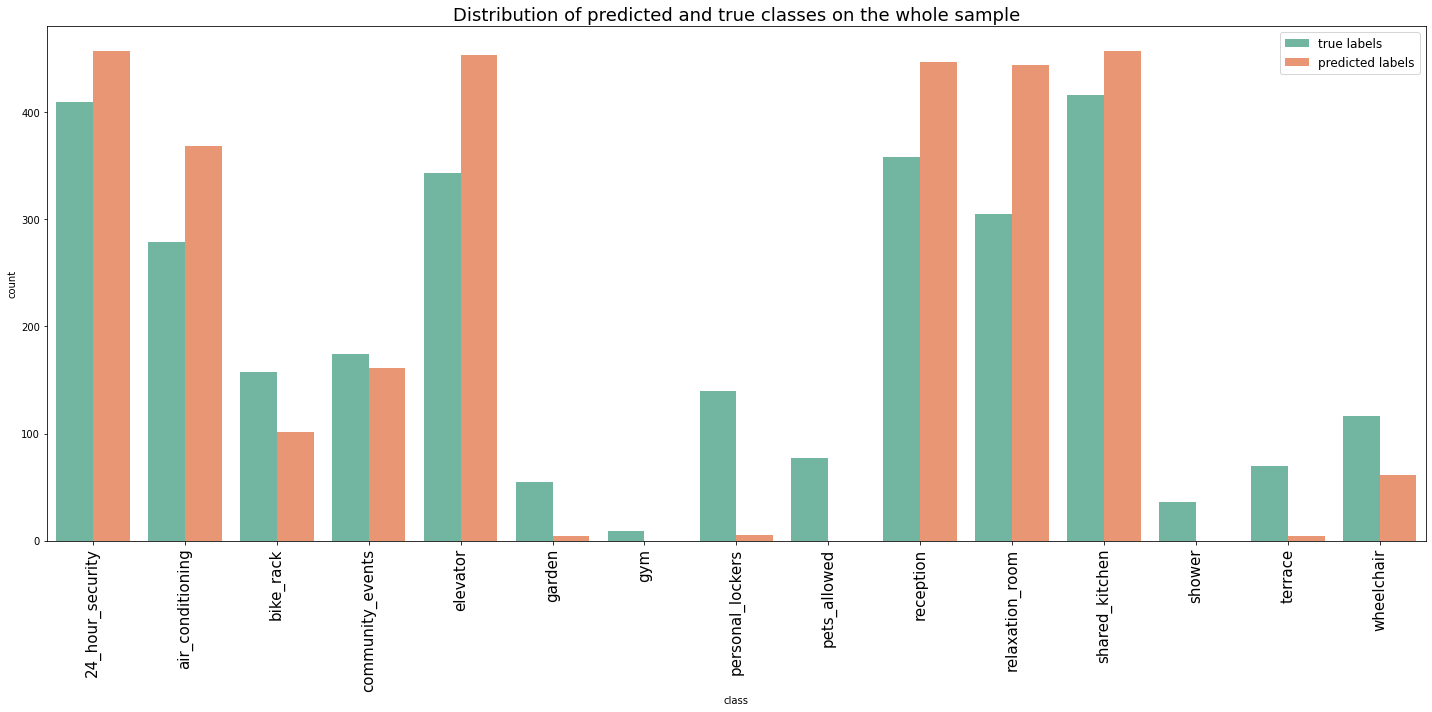

In [ ]:
plot_true_preds(all_preds_listing, df)

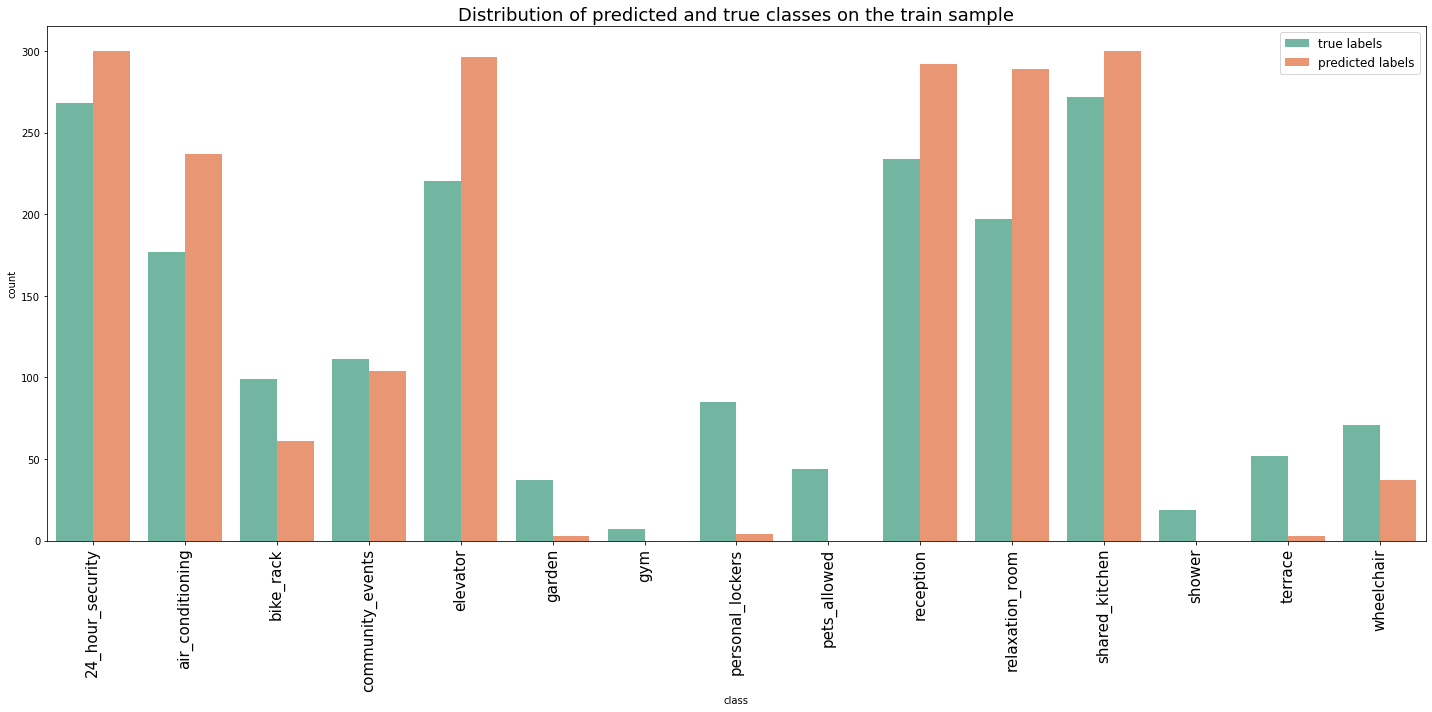

In [ ]:
plot_true_preds(train_preds_listing, df, sample_name = 'train')

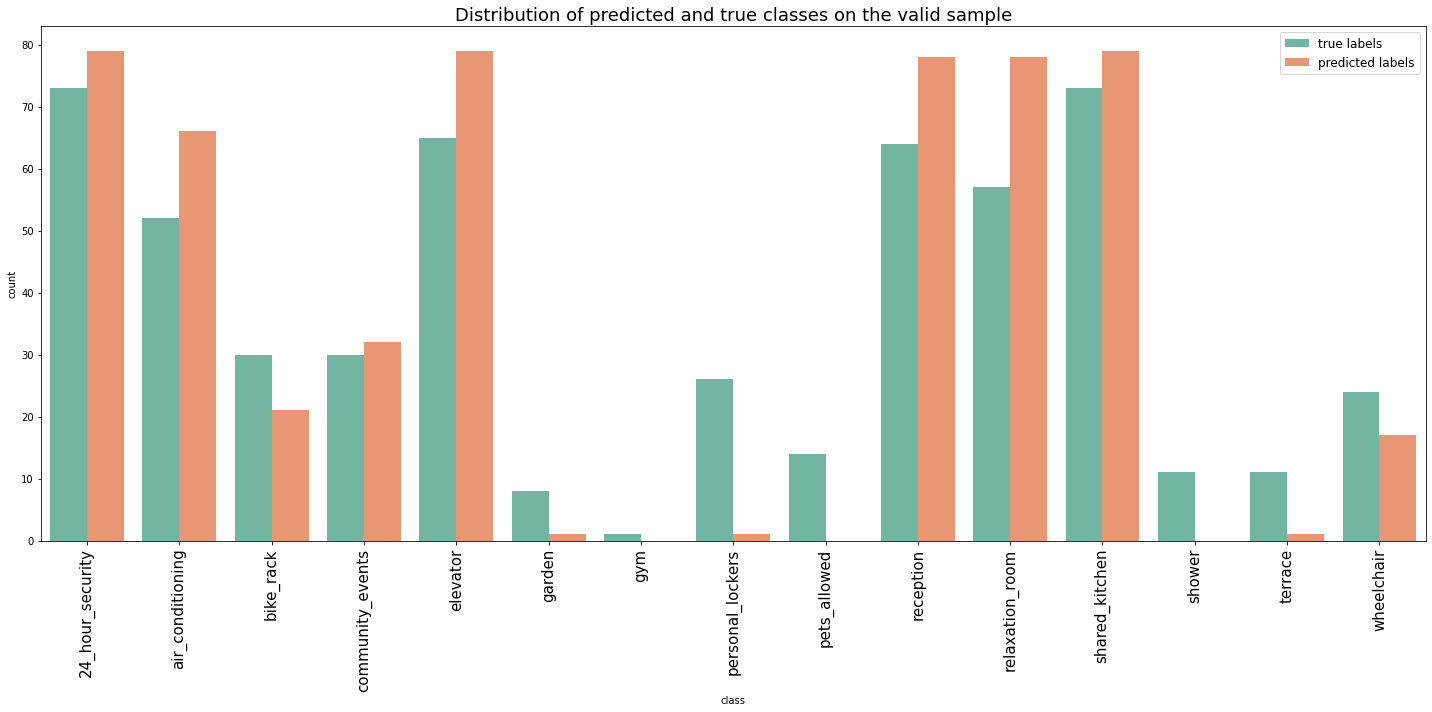

In [ ]:
plot_true_preds(valid_preds_listing, df, sample_name = 'valid')

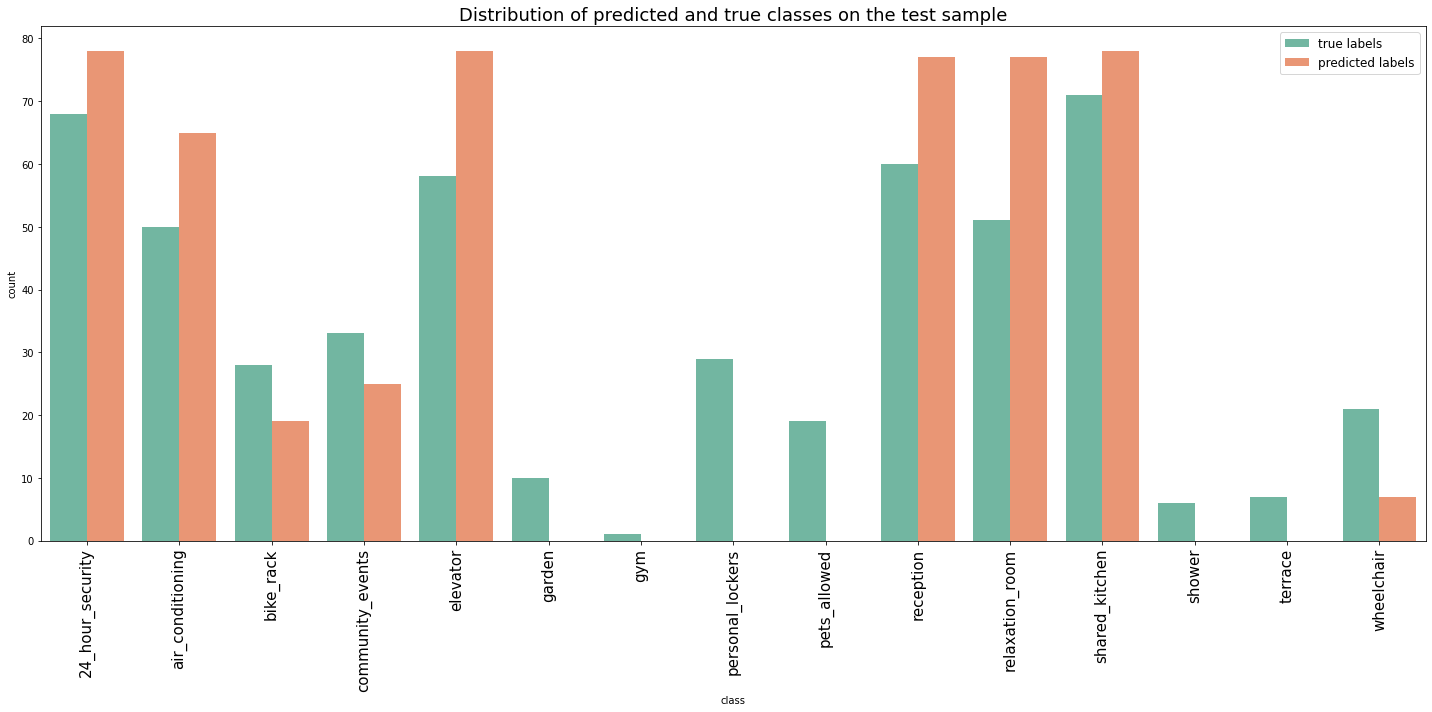

In [ ]:
plot_true_preds(test_preds_listing, df, sample_name = 'test')

Exporting the data structures used in the evaluation (such as predictions, label names, number of pictures and office names per sample, etc.)

In [ ]:
export_dict = {
               'df': df,

               'label_names':label_names,

               'num_pics':{'train':train_num_pics,
                           'valid':valid_num_pics,
                           'test':test_num_pics,
                           'all':all_num_pics},
               
               'offices':{'train':train_offices,
                          'valid':valid_offices,
                          'test':test_offices,
                          'all':all_offices},
                'metrics_list':metrics_list,
               
                'predictions':{'train':train_all_predictions,
                              'valid':valid_all_predictions,
                              'test':test_all_predictions,
                              'all':all_predictions},
               
                'overall_evaluation':{'train':train_overall_ev_df,
                                'valid':valid_overall_ev_df,
                                'test':test_overall_ev_df,
                                'all': df_ev_overall},
               
                'preds_listing':{'train':train_preds_listing,
                                'valid':valid_preds_listing,
                                'test':test_preds_listing,
                                'all':all_preds_listing}
              }

In [ ]:
with open('export_dict.pkl', 'wb') as f:
  pickle.dump(export_dict,f)